In [1]:
# Paths
import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

os.chdir('../..')
from pcmf import pcmf_full, path_plot, plot_ordercolor, plot_cluster_assignments, PCMF_predict_clusters
from p3ca import cluster_metrics, calculate_scores_nonpath
import numpy as np
%load_ext autoreload


In [2]:
# Functions
def run_fitPCMF_experiment_consensusICML2023(savedir='/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/',dataset='MNIST', problem_rank=100, rho=2.0, gc=1.0, neighbors=40, admm_iters=2, penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,10))[::-1]),axis=0), skip=1, labels_keep=[0,1,2,3,4,5], data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/',randomize=False):
    from pcmf import pcmf_full_consensus_2023 as pcmf_consensus
    import time
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    # LOAD DATA
    batch_size = 50
    if dataset == 'MNIST':
        save_path=savedir+'MNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'FashionMNIST':
        save_path=savedir+'FashionMNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'GBMBreastLung':
        save_path=savedir+'GBMBreastLung_'+'skip'+str(skip)+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path=data_path, plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'Synthetic':
        save_path=savedir+'Synthetic100000_'+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true = load_syntheticDataConsensus(n=100000, n_test=10000, p=1000, m=25000, m_test=2500, plot=False, randomize=randomize)
    else:
        print('Dataset not implemented:',dataset)
        return
    
    print('Problem rank',problem_rank)
    print('Save path is:',save_path+'.npz')

    # STANDARDIZE DATA
    scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
    X_in = scaler.transform(X_in)
    normalizer = Normalizer().fit(X_in)
    X_in = normalizer.transform(X_in)
    scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
    X_in = scaler2.transform(X_in)

    X_in_test = scaler.transform(X_in_test)
    X_in_test = normalizer.transform(X_in_test)
    X_in_test = scaler2.transform(X_in_test)

    # Fit PCMF
    tic=time.time()
    A_list, U_list, s_list, V_list = pcmf_consensus(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
    toc=time.time() - tic
    
    A = A_list
    U = U_list
    S = s_list
    V = V_list

    X_compA = []
    X_compB = []
    UV = []
    USV = []
    for p in range(len(penalty_list)):
        x_pcmf = U[p]*S[p][:,0] # should the 0 be here??
        x_pcmf2 = (X_in[:,:] @ V[p].T) 
        X_compA.append(np.array(x_pcmf))
        X_compB.append(np.array(x_pcmf2))
        UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
        USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

    X_compA=np.asarray(X_compA)
    X_compB=np.asarray(X_compB)
    
    # SAVE DATASET    
    np.savez(save_path+".npz",  A=A, U=U, S=S, V=V, UV=UV, USV=USV, X_compA=X_compA, X_compB=X_compB, X_in=X_in, true_clusters_in=true_clusters_in, X_in_test=X_in_test, true_clusters_in_test=true_clusters_in_test, true_clusters_labels=true_clusters_labels, num_clusters=num_clusters, u_true=u_true, v_true=v_true, split_size=batch_size, runtime=toc, penalty_list=np.asarray(penalty_list), rho=rho, admm_iters=admm_iters, gc=gc, neighbors=neighbors) 
#     generate_plots_synthetic(A, U, V, S, split_size, penalty_list, true_clusters_all, save_path+".pdf")
    del A, U, S, V, UV, USV, X_compA, X_compB, X_in, true_clusters_in, toc
    
    return save_path+".npz"

from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog, linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

# MNIST
def load_MNIST(labels_keep=[0,3,5], plot=False, skip=1, batch_size=50, randomize=False):
    import numpy as np
    from keras.datasets import mnist
    from matplotlib import pyplot
    import pandas as pd
    
    print('Loading MNIST')
    # Loading
    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    # Shape of dataset
    print('X_train: ' + str(train_X.shape))
    print('Y_train: ' + str(train_y.shape))
    print('X_test:  '  + str(test_X.shape))
    print('Y_test:  '  + str(test_y.shape))

    if plot is True:
        # Plotting
        from matplotlib import pyplot
        for i in range(9):  
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
            pyplot.show()

    # Select data corresponding to a subset of the latbels
    inds = []
    inds_test = []
    for ind in labels_keep:
        inds.append(np.where(train_y==ind)[0])
        inds_test.append(np.where(test_y==ind)[0])
        
    inds = np.hstack(inds)
    inds_test = np.hstack(inds_test)

    # Select training set
    X_in = train_X[inds,:].reshape((train_X[inds,:].shape[0],28*28))
    true_clusters_in = pd.factorize(train_y[inds])[0]
    
    # Randomize training setorder
    if randomize is True:
        print('Randomizing order seed 42')
        idxs = np.random.RandomState(seed=42).permutation(X_in.shape[0])
        X_in2 = X_in[idxs,:]
        true_clusters_in2 = true_clusters_in[idxs]
        
        X_in = X_in2
        true_clusters_in = true_clusters_in2
        del X_in2, true_clusters_in2

    # subset evenly sampled across remaining n_X using skip
    X_in = X_in[::skip]
    true_clusters_in = true_clusters_in[::skip]
    true_clusters_labels = pd.factorize(train_y[inds])[1]
    num_clusters = len(np.unique(true_clusters_in))
    print('X_train',X_in.shape, 'Y_train', true_clusters_in.shape)    
    print('Class labels',true_clusters_labels,'indexed as',np.unique(true_clusters_in))    
    # Select test set
    X_in_test = test_X[inds_test,:].reshape((test_X[inds_test,:].shape[0],28*28))
    true_clusters_in_test = pd.factorize(test_y[inds_test])[0]
    print('X_test',X_in.shape, 'Y_test', true_clusters_in.shape)

    # Subset training set to be a multiple of the batch size, batch_size
    n_X = X_in.shape[0]
    mod = n_X % batch_size
    n_X_new = n_X - mod
    print('n_X', n_X, 'batch size', batch_size, 'modulo', mod, 'is now', 'n_X', n_X_new, 'batch size', batch_size, 'modulo', (n_X - mod) % batch_size)

    X_in = X_in[0:n_X_new,:]
    true_clusters_in = true_clusters_in[0:n_X_new]

    print('Training set is now:', X_in.shape, true_clusters_in.shape)
    
    return X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters

    
    


In [3]:
# Load MNIST
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=30, batch_size=50, randomize=False)




Loading MNIST
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_train (1201, 784) Y_train (1201,)
Class labels [0 1 2 3 4 5] indexed as [0 1 2 3 4 5]
X_test (1201, 784) Y_test (1201,)
n_X 1201 batch size 50 modulo 1 is now n_X 1200 batch size 50 modulo 0
Training set is now: (1200, 784) (1200,)


In [9]:
# savedir = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/'
# data_path = '/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/'
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,5))[::-1]),axis=0)
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)

penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)

# randomize = False
# rho = 0.25
# gc = 0.5
# neighbors = 25
# admm_iters = 2 #15#2#15
# skip = 3#20
# labels_keep = [0,1,2,3,4,5]
# data_path = run_fitPCMF_experiment_consensusICML2023(dataset='MNIST', rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)


penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,30))[::-1]),axis=0)
randomize = False
rho = 2.0
gc = 1.0
neighbors = 40
admm_iters = 2 #15#2#15
skip = 1#20
labels_keep = [0,1,2,3,4,5]
data_path = run_fitPCMF_experiment_consensusICML2023(dataset='MNIST', rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)

penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,50))[::-1]),axis=0)
randomize = False
rho = 2.0
gc = 1.0
neighbors = 40
admm_iters = 5 #15#2#15
skip = 1#20
labels_keep = [0,1,2,3,4,5]
data_path = run_fitPCMF_experiment_consensusICML2023(dataset='MNIST', rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)

# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,10))[::-1]),axis=0)
# randomize = False
# rho = 0.25
# gc = 0.5
# neighbors = 25
# admm_iters = 10 #15#2#15
# skip = 1#20
# labels_keep = [0,1,2,3,4,5]
# problem_rank=15
# data_path = run_fitPCMF_experiment_consensusICML2023(dataset='MNIST', problem_rank=problem_rank, rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)



Loading MNIST
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_train (36017, 784) Y_train (36017,)
Class labels [0 1 2 3 4 5] indexed as [0 1 2 3 4 5]
X_test (36017, 784) Y_test (36017,)
n_X 36017 batch size 50 modulo 17 is now n_X 36000 batch size 50 modulo 0
Training set is now: (36000, 784) (36000,)
Problem rank 100
Save path is: /Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/MNIST_skip1_nclusters6_batchSize_50_pathLength35problem_rank100_gausscoef1.0_neighbors40_admm_iters2_rho2.0_randomizeFalse.npz
weights: Gaussian neighbors: 40 gauss_coef: 1.0 rho: 2.0
rho1: 2.0 rho2 2.0
Number of batches: 720
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Initialize IDX: 4
Initialize IDX: 5
Initialize IDX: 6
Initialize IDX: 7
Initialize IDX: 8
Initialize IDX: 9
Initialize IDX: 10
Initialize IDX: 11
Initialize IDX: 12
Initialize IDX: 13
Initialize IDX: 14
Initialize IDX: 15
Initialize IDX: 16
Initialize IDX: 17
Initial

Initialize IDX: 388
Initialize IDX: 389
Initialize IDX: 390
Initialize IDX: 391
Initialize IDX: 392
Initialize IDX: 393
Initialize IDX: 394
Initialize IDX: 395
Initialize IDX: 396
Initialize IDX: 397
Initialize IDX: 398
Initialize IDX: 399
Initialize IDX: 400
Initialize IDX: 401
Initialize IDX: 402
Initialize IDX: 403
Initialize IDX: 404
Initialize IDX: 405
Initialize IDX: 406
Initialize IDX: 407
Initialize IDX: 408
Initialize IDX: 409
Initialize IDX: 410
Initialize IDX: 411
Initialize IDX: 412
Initialize IDX: 413
Initialize IDX: 414
Initialize IDX: 415
Initialize IDX: 416
Initialize IDX: 417
Initialize IDX: 418
Initialize IDX: 419
Initialize IDX: 420
Initialize IDX: 421
Initialize IDX: 422
Initialize IDX: 423
Initialize IDX: 424
Initialize IDX: 425
Initialize IDX: 426
Initialize IDX: 427
Initialize IDX: 428
Initialize IDX: 429
Initialize IDX: 430
Initialize IDX: 431
Initialize IDX: 432
Initialize IDX: 433
Initialize IDX: 434
Initialize IDX: 435
Initialize IDX: 436
Initialize IDX: 437


FileNotFoundError: [Errno 2] No such file or directory: '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/MNIST_skip1_nclusters6_batchSize_50_pathLength35problem_rank100_gausscoef1.0_neighbors40_admm_iters2_rho2.0_randomizeFalse.npz'

In [11]:
data_path = '/athena/listonlab/store/amb2022/PCMF/results_ICML2023/MNIST_skip1_nclusters6_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters2_rho2.0.npz'
# data_path = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/MNIST_skip1_nclusters6_batchSize_50_pathLength35problem_rank100_gausscoef1.0_neighbors40_admm_iters2_rho2.0_randomizeFalse.npz'
print(data_path)
results = np.load(data_path, allow_pickle=True)

A = results['A']
U = results['U']
V = results['V']
S = results['S']
UV = results['UV']
USV = results['USV']
X_compA = results['X_compA']
X_compB = results['X_compB']
X_in = results['X_in']
true_clusters_in = results['true_clusters_in']
X_in_test = results['X_in_test']
true_clusters_in_test = results['true_clusters_in_test']
true_clusters_labels = results['true_clusters_labels']
num_clusters = results['num_clusters']
u_true = results['u_true']
v_true = results['v_true']
split_size = results['split_size']
toc = results['runtime']
penalty_list = results['penalty_list']
rho = results['rho']
admm_iters = results['admm_iters']
gc = results['gc']
neighbors = results['neighbors']

print(toc)


/athena/listonlab/store/amb2022/PCMF/results_ICML2023/MNIST_skip1_nclusters6_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters2_rho2.0.npz
977.071594953537


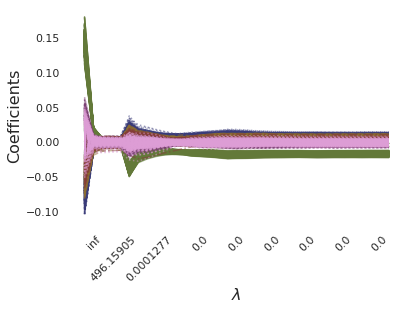

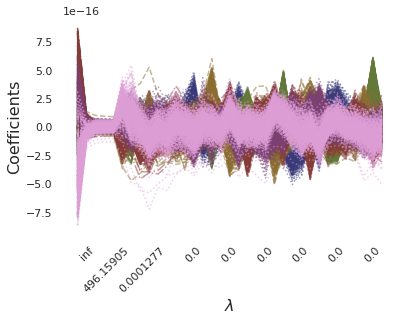

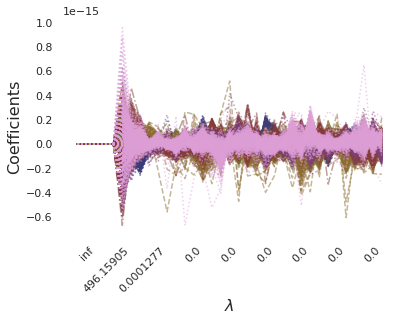

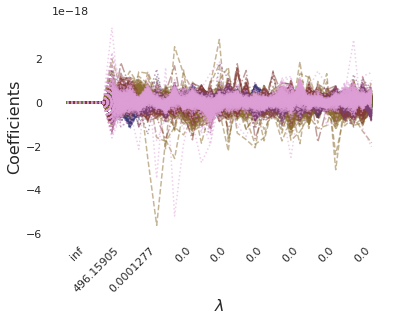

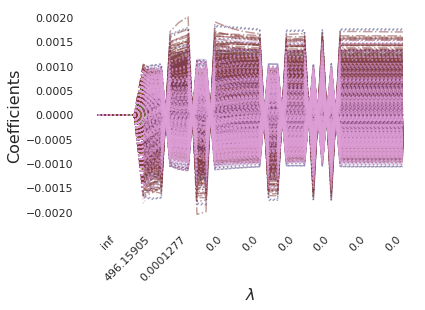

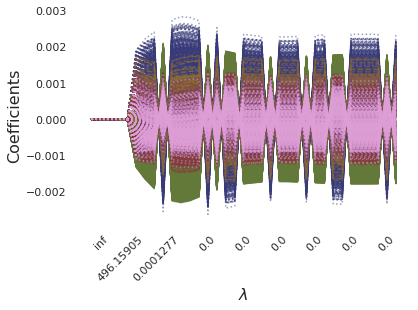

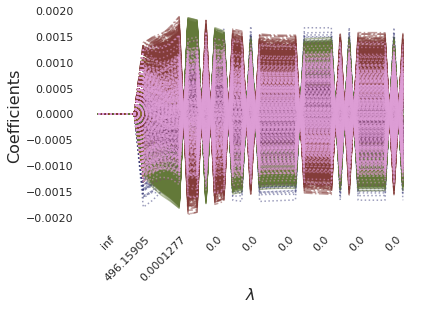

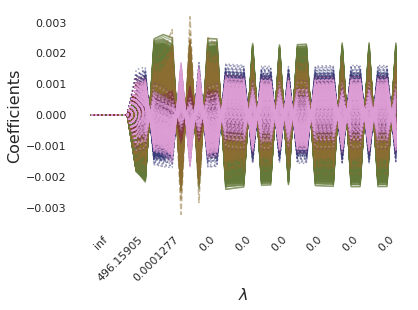

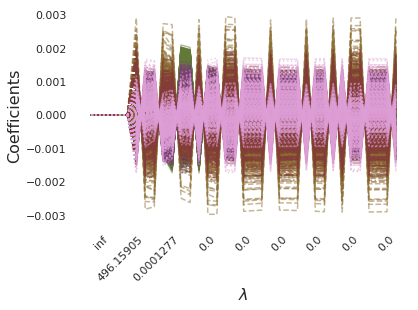

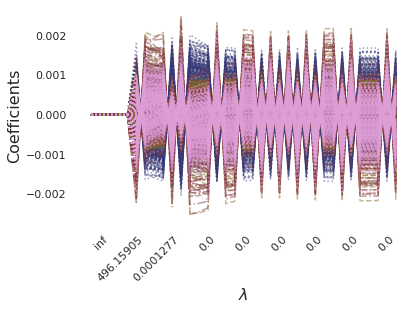

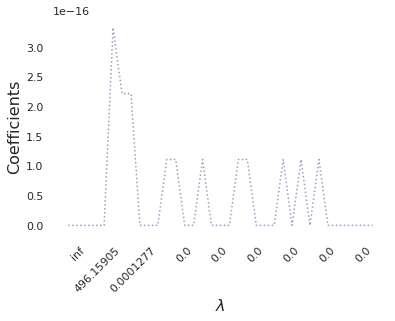

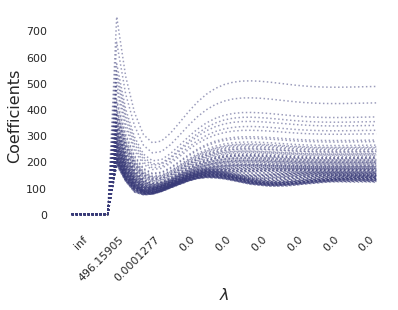

In [6]:
from matplotlib import pyplot as plt
def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
skip=10

path_plot(np.mean(np.asarray(A),axis=2)[:,:,np.newaxis][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(A)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(USV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(UV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,1:2][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,2:3][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,3:4][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,4:5][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,5:6][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(V)[:,0:4,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(S)[:,:,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


In [7]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    import sklearn
    
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(P,sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), acc)

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = 100
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
# pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), toc)



0 0.0 0.18727777777777777
1 0.0 0.18727777777777777
2 0.0 0.18727777777777777
3 0.0 0.18727777777777777
4 0.0 0.18727777777777777
5 0.9180543665553135 0.9643333333333334
6 0.989224618245147 0.9954444444444445
7 0.998249131534674 0.9992777777777778
8 0.9979906376127495 0.9991666666666666
9 0.9974017874970486 0.9989166666666667
10 0.9971424162416993 0.9988055555555555
11 0.9974447280661555 0.9989444444444444
12 0.9969060682820996 0.9986944444444444
13 0.9958707572431927 0.99825
14 0.995474418404799 0.9980833333333333
15 0.9934201537045506 0.9971944444444445
16 0.992217643054608 0.9966944444444444
17 0.9911200946520895 0.9961944444444445
18 0.9912675609904303 0.9962777777777778
19 0.9918035439433625 0.9965
20 0.9913595004759501 0.9963333333333333
21 0.9925238409952273 0.9968333333333333
22 0.9919932229963154 0.9966111111111111
23 0.9927984998044366 0.9969444444444444
24 0.9928615654817002 0.9969722222222223
25 0.9931394430438898 0.9970833333333333
26 0.9933321449168577 0.9971666666666666


In [8]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
    print(P)
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    PCMF_predict_clusters(X_in_test, UV[P], V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
    PCMF_predict_clusters(X_in_test, X_in, V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)

# # %aimport 
# from pcmf import PCMF_predict_clusters
# for P in range(len(penalty_list)):
#     print(P)
#     PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
#     PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



0
Test set cluster accuracy: 0.18819432929862379
Test set cluster accuracy: 0.18819432929862379
1
Test set cluster accuracy: 0.18819432929862379
Test set cluster accuracy: 0.18819432929862379
2
Test set cluster accuracy: 0.18819432929862379
Test set cluster accuracy: 0.18819432929862379
3
Test set cluster accuracy: 0.18819432929862379
Test set cluster accuracy: 0.18819432929862379
4
Test set cluster accuracy: 0.18819432929862379
Test set cluster accuracy: 0.18819432929862379
5
Test set cluster accuracy: 0.8817774830044769
Test set cluster accuracy: 0.8777980434422152
6
Test set cluster accuracy: 0.8826065329132814
Test set cluster accuracy: 0.8797877632233461
7
Test set cluster accuracy: 0.883269772840325
Test set cluster accuracy: 0.8791245232963024
8
Test set cluster accuracy: 0.8804510031503896
Test set cluster accuracy: 0.8768031835516498
9
Test set cluster accuracy: 0.8642016249378213
Test set cluster accuracy: 0.8575692256673851
10
Test set cluster accuracy: 0.8547504559774498
Te

In [39]:
# del sys.modules["scanpy"]
# del scanpy
import scanpy as sc
sc.__version__

ImportError: cannot import name '_get_obs_rep' from 'scanpy.get' (/home/amb2022/.conda/envs/mamba/lib/python3.7/site-packages/scanpy/get.py)

In [33]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
dataset_x = X_in.astype(np.float32)
dataset_y = true_clusters_in.astype(np.int32)
adata = AnnData(dataset_x)
adata
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=5)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]


AttributeError: 'tuple' object has no attribute 'tocsr'

In [14]:
        
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=15)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Louvain ACC',acc)



AttributeError: 'tuple' object has no attribute 'tocsr'

## DEC

In [40]:
import sys
import numpy as np
import keras.backend as K
from keras.initializers import RandomNormal
# from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import normalize
from keras.callbacks import LearningRateScheduler
# from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
if (sys.version[0] == 2):
    import cPickle as pickle
else:
    import pickle
import numpy as np

In [41]:
class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self._trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeepEmbeddingClustering(object):
    def __init__(self,
                 n_clusters,
                 input_dim,
                 encoded=None,
                 decoded=None,
                 alpha=1.0,
                 pretrained_weights=None,
                 cluster_centres=None,
                 batch_size=256,
                 **kwargs):

        super(DeepEmbeddingClustering, self).__init__()

        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.encoded = encoded
        self.decoded = decoded
        self.alpha = alpha
        self.pretrained_weights = pretrained_weights
        self.cluster_centres = cluster_centres
        self.batch_size = batch_size

        self.learning_rate = 0.1
        self.iters_lr_update = 20000
        self.lr_change_rate = 0.1

        # greedy layer-wise training before end-to-end training:

        self.encoders_dims = [self.input_dim, 500, 500, 2000, 10]

        self.input_layer = Input(shape=(self.input_dim,), name='input')
        dropout_fraction = 0.2
        init_stddev = 0.01

        self.layer_wise_autoencoders = []
        self.encoders = []
        self.decoders = []
        for i  in range(1, len(self.encoders_dims)):
            
            encoder_activation = 'linear' if i == (len(self.encoders_dims) - 1) else 'relu'
            encoder = Dense(self.encoders_dims[i], activation=encoder_activation,
                            input_shape=(self.encoders_dims[i-1],),
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros', name='encoder_dense_%d'%i)
            self.encoders.append(encoder)

            decoder_index = len(self.encoders_dims) - i
            decoder_activation = 'linear' if i == 1 else 'relu'
            decoder = Dense(self.encoders_dims[i-1], activation=decoder_activation,
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros',
                            name='decoder_dense_%d'%decoder_index)
            self.decoders.append(decoder)

            autoencoder = Sequential([
                Dropout(dropout_fraction, input_shape=(self.encoders_dims[i-1],), 
                        name='encoder_dropout_%d'%i),
                encoder,
                Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
                decoder
            ])
            autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
            self.layer_wise_autoencoders.append(autoencoder)

        # build the end-to-end autoencoder for finetuning
        # Note that at this point dropout is discarded
        self.encoder = Sequential(self.encoders)
        self.encoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
        self.decoders.reverse()
        self.autoencoder = Sequential(self.encoders + self.decoders)
        self.autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))

        if cluster_centres is not None:
            assert cluster_centres.shape[0] == self.n_clusters
            assert cluster_centres.shape[1] == self.encoder.layers[-1].output_dim

        if self.pretrained_weights is not None:
            self.autoencoder.load_weights(self.pretrained_weights)

    def p_mat(self, q):
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def initialize(self, X, save_autoencoder=False, layerwise_pretrain_iters=50000, finetune_iters=100000):
        if self.pretrained_weights is None:

            iters_per_epoch = int(len(X) / self.batch_size)
            layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
            finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

            print('layerwise pretrain')
            current_input = X
            lr_epoch_update = max(1, self.iters_lr_update / float(iters_per_epoch))
            
            def step_decay(epoch):
                initial_rate = self.learning_rate
                factor = int(epoch / lr_epoch_update)
                lr = initial_rate / (10 ** factor)
                return lr
            lr_schedule = LearningRateScheduler(step_decay)

            for i, autoencoder in enumerate(self.layer_wise_autoencoders):
                if i > 0:
                    weights = self.encoders[i-1].get_weights()
                    dense_layer = Dense(self.encoders_dims[i], input_shape=(current_input.shape[1],),
                                        activation='relu', weights=weights,
                                        name='encoder_dense_copy_%d'%i)
                    encoder_model = Sequential([dense_layer])
                    encoder_model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
                    current_input = encoder_model.predict(current_input)

                autoencoder.fit(current_input, current_input, 
                                batch_size=self.batch_size, epochs=layerwise_epochs, callbacks=[lr_schedule])
                self.autoencoder.layers[i].set_weights(autoencoder.layers[1].get_weights())
                self.autoencoder.layers[len(self.autoencoder.layers) - i - 1].set_weights(autoencoder.layers[-1].get_weights())
            
            print('Finetuning autoencoder')
            
            #update encoder and decoder weights:
            self.autoencoder.fit(X, X, batch_size=self.batch_size, epochs=finetune_epochs, callbacks=[lr_schedule])

            if save_autoencoder:
                self.autoencoder.save_weights('autoencoder.h5')
        else:
            print('Loading pretrained weights for autoencoder.')
            self.autoencoder.load_weights(self.pretrained_weights)

        # update encoder, decoder
        # TODO: is this needed? Might be redundant...
        for i in range(len(self.encoder.layers)):
            self.encoder.layers[i].set_weights(self.autoencoder.layers[i].get_weights())

        # initialize cluster centres using k-means
        print('Initializing cluster centres with k-means.')
        if self.cluster_centres is None:
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            self.y_pred = kmeans.fit_predict(self.encoder.predict(X))
            self.cluster_centres = kmeans.cluster_centers_

        # prepare DEC model
        #self.DEC = Model(inputs=self.input_layer,
        #                 outputs=ClusteringLayer(self.n_clusters,
        #                                        weights=self.cluster_centres,
        #                                        name='clustering')(self.encoder))
        self.DEC = Sequential([self.encoder,
                             ClusteringLayer(self.n_clusters,
                                                weights=self.cluster_centres,
                                                name='clustering')])
        self.DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
        return

    def cluster_acc(self, y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
#         return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w
        return sum([w[i, j] for i, j in zip(ind[0],ind[1])])*1.0/y_pred.size, w


    def cluster(self, X, y=None,
                tol=0.01, update_interval=None,
                iter_max=1e6,
                save_interval=None,
                **kwargs):

        if update_interval is None:
            # 1 epochs
            update_interval = X.shape[0]/self.batch_size
        print('Update interval', update_interval)

        if save_interval is None:
            # 50 epochs
            save_interval = X.shape[0]/self.batch_size*50
        print('Save interval', save_interval)

        assert save_interval >= update_interval

        train = True
        iteration, index = 0, 0
        self.accuracy = []

        while train:
            sys.stdout.write('\r')
            # cutoff iteration
            if iter_max < iteration:
                print('Reached maximum iteration limit. Stopping training.')
                return self.y_pred

            # update (or initialize) probability distributions and propagate weight changes
            # from DEC model to encoder.
            if iteration % update_interval == 0:
                self.q = self.DEC.predict(X, verbose=0)
                self.p = self.p_mat(self.q)

                y_pred = self.q.argmax(1)
                delta_label = ((y_pred == self.y_pred).sum().astype(np.float32) / y_pred.shape[0])
                if y is not None:
#                     acc, w = self.cluster_acc(y, y_pred)
                    acc = self.cluster_acc(y, y_pred)[0]
                    self.accuracy.append(acc)
                    print('Iteration '+str(iteration)+', Accuracy '+str(np.round(acc, 5)))
                else:
                    print(str(np.round(delta_label*100, 5))+'% change in label assignment')

                if delta_label < tol:
                    print('Reached tolerance threshold. Stopping training.')
                    train = False
                    continue
                else:
                    self.y_pred = y_pred

                for i in range(len(self.encoder.layers)):
                    self.encoder.layers[i].set_weights(self.DEC.layers[0].layers[i].get_weights())
                self.cluster_centres = self.DEC.layers[-1].get_weights()[0]

            # train on batch
            sys.stdout.write('Iteration %d, ' % iteration)
            if (index+1)*self.batch_size > X.shape[0]:
                loss = self.DEC.train_on_batch(X[index*self.batch_size::], self.p[index*self.batch_size::])
                index = 0
                sys.stdout.write('Loss %f' % loss)
            else:
                loss = self.DEC.train_on_batch(X[index*self.batch_size:(index+1) * self.batch_size],
                                               self.p[index*self.batch_size:(index+1) * self.batch_size])
                sys.stdout.write('Loss %f' % loss)
                index += 1

            # save intermediate
            if iteration % save_interval == 0:
                z = self.encoder.predict(X)
                pca = PCA(n_components=2).fit(z)
                z_2d = pca.transform(z)
                clust_2d = pca.transform(self.cluster_centres)
                # save states for visualization
                pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': self.q, 'p': self.p},
                            open('c'+str(iteration)+'.pkl', 'wb'))
                # save DEC model checkpoints
                self.DEC.save('DEC_model_'+str(iteration)+'.h5')

            iteration += 1
            sys.stdout.flush()
        return

In [42]:
import os
import sys
import multiprocessing  
import time
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_decomposition import CCA
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

def calculate_scores_nonpath(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
     
    return nmi_score, adj_rand_score, ri_score, mse_score

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord



In [50]:
# RUN DEC Grid Search
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X = scalerX.fit_transform(X_in).astype(np.float32)
Y = true_clusters_in.astype(np.int32)

batch_size_options = [15, 30]
finetune_iters_options= [100, 1000]
layerwise_pretrain_iters_options= [100, 1000]
cluster_iter_max_options = [100, 200]
idx = 0
accuracies = []

for batch_size in batch_size_options:
    for finetune_iters in finetune_iters_options:
        for layerwise_pretrain_iters in layerwise_pretrain_iters_options:
                for cluster_iter_max in cluster_iter_max_options:
                    c = DeepEmbeddingClustering(n_clusters=len(np.unique(Y)), input_dim=X.shape[1], batch_size=batch_size)
                    c.initialize(X, finetune_iters=finetune_iters, layerwise_pretrain_iters=1000)

                    labels = c.cluster(X, y=Y, iter_max=100)
#                     print(c.accuracy)

                    # Calculate accuracy
                    conf_mat_ord = confusion_matrix_ordered(labels,Y)
                    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
                    print('IDX:',idx, 'Accuracy:', acc, 'Batch size:',batch_size, 'finetune_iters:',finetune_iters, 'layerwise_pretrain_iters:',layerwise_pretrain_iters, 'cluster_iter_max:',cluster_iter_max)
                    idx = idx+1
                    
                    accuracies.append([idx,acc, batch_size, finetune_iters, layerwise_pretrain_iters, cluster_iter_max,])

                    

layerwise pretrain
2400/2400 [==============================] - 3s 1ms/step - loss: nan - lr: 0.1000
Finetuning autoencoder
2400/2400 [==============================] - 12s 5ms/step - loss: nan - lr: 0.1000
Initializing cluster centres with k-means.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## CARDEC

In [5]:
def load_MNIST(labels_keep=[0,3,5], plot=False, skip=1, batch_size=50, randomize=False):
    import numpy as np
    from keras.datasets import mnist
    from matplotlib import pyplot
    import pandas as pd
    
    print('Loading MNIST')
    # Loading
    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    # Shape of dataset
    print('X_train: ' + str(train_X.shape))
    print('Y_train: ' + str(train_y.shape))
    print('X_test:  '  + str(test_X.shape))
    print('Y_test:  '  + str(test_y.shape))

    if plot is True:
        # Plotting
        from matplotlib import pyplot
        for i in range(9):  
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
            pyplot.show()

    # Select data corresponding to a subset of the latbels
    inds = []
    inds_test = []
    for ind in labels_keep:
        inds.append(np.where(train_y==ind)[0])
        inds_test.append(np.where(test_y==ind)[0])
        
    inds = np.hstack(inds)
    inds_test = np.hstack(inds_test)

    # Select training set
    X_in = train_X[inds,:].reshape((train_X[inds,:].shape[0],28*28))
    true_clusters_in = pd.factorize(train_y[inds])[0]
    
    # Randomize training setorder
    if randomize is True:
        print('Randomizing order seed 42')
        idxs = np.random.RandomState(seed=42).permutation(X_in.shape[0])
        X_in2 = X_in[idxs,:]
        true_clusters_in2 = true_clusters_in[idxs]
        
        X_in = X_in2
        true_clusters_in = true_clusters_in2
        del X_in2, true_clusters_in2

    # subset evenly sampled across remaining n_X using skip
    X_in = X_in[::skip]
    true_clusters_in = true_clusters_in[::skip]
    true_clusters_labels = pd.factorize(train_y[inds])[1]
    num_clusters = len(np.unique(true_clusters_in))
    print('X_train',X_in.shape, 'Y_train', true_clusters_in.shape)    
    print('Class labels',true_clusters_labels,'indexed as',np.unique(true_clusters_in))    
    # Select test set
    X_in_test = test_X[inds_test,:].reshape((test_X[inds_test,:].shape[0],28*28))
    true_clusters_in_test = pd.factorize(test_y[inds_test])[0]
    print('X_test',X_in.shape, 'Y_test', true_clusters_in.shape)

    # Subset training set to be a multiple of the batch size, batch_size
    n_X = X_in.shape[0]
    mod = n_X % batch_size
    n_X_new = n_X - mod
    print('n_X', n_X, 'batch size', batch_size, 'modulo', mod, 'is now', 'n_X', n_X_new, 'batch size', batch_size, 'modulo', (n_X - mod) % batch_size)

    X_in = X_in[0:n_X_new,:]
    true_clusters_in = true_clusters_in[0:n_X_new]

    print('Training set is now:', X_in.shape, true_clusters_in.shape)
    
    return X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters

import pandas as pd
def load_data(X_in,true_clusters_in):
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    scalerX = StandardScaler()
    scalerX.fit(X_in)
    x = scalerX.transform(X_in)

    y = pd.factorize(true_clusters_in)[0].astype(np.int32)
    print(y.shape)

    print('samples', x.shape, y.shape)
    return x, y

from torch.utils.data import Dataset
class inDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_data(X_in,true_clusters_in)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


In [71]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
data_dir = '/athena/listonlab/store/amb2022/PCMF/'
os.chdir(data_dir)
dataset = inDataset()
scaler = MinMaxScaler()
dataset.x = scaler.fit_transform(dataset.x)
adata = AnnData(dataset.x)

n_top_genes_options = [2]
n_neighbors_options = [5, 10, 15, 20, 25]
idx = 0
accuracies = []
for n_neighbors in n_neighbors_options:
    for n_top_genes in n_top_genes_options:
        from sklearn.preprocessing import MinMaxScaler
        sc.pp.pca(adata)
        sc.pp.neighbors(adata,n_neighbors=n_neighbors)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata) # ,n_top_genes=n_top_genes
        # Initialize and pretrain weights
        CarDEC = CarDEC_API(adata, weights_dir = "./data/MNIST_Weights_NN"+str(n_neighbors)+'_NG'+str(n_top_genes), preprocess=True, normalize_samples=False, log_normalize=False, normalize_features=False, batch_key = None, LVG = True, n_high_var = 1)
        # Build model
        grad = grad_reconstruction
        CarDEC.build_model(n_clusters = len(np.unique(dataset.y)))
        # # Train CarDEC model using autodifferentiation and save weights
        grad = grad_MainModel
        CarDEC.make_inference()

        temporary = AnnData(CarDEC.dataset.obsm['embedding'])
        temporary.obs = CarDEC.dataset.obs
        sc.tl.pca(temporary, svd_solver='arpack')
        sc.pp.neighbors(temporary, n_neighbors = n_neighbors)
        y_pred = np.argmax(CarDEC.dataset.obsm['cluster memberships'],axis=1)

        # Calculate accuracy
        conf_mat_ord = confusion_matrix_ordered(dataset.y, y_pred)
        acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        print('IDX:',idx, 'Accuracy:', acc, 'n_neighbors:',n_neighbors, 'n_top_genes:',n_top_genes)
        idx = idx+1

        accuracies.append([idx, acc, n_neighbors, n_top_genes])



(36000,)
samples (36000, 784) (36000,)


ImportError: cannot import name '_get_obs_rep' from 'scanpy.get' (/home/amb2022/.conda/envs/mamba/lib/python3.7/site-packages/scanpy/get.py)

## IDEC

In [4]:
# -*- coding: utf-8 -*-
#
# Copyright © dawnranger.
#
# 2018-05-08 10:15 <dawnranger123@gmail.com>
#
# Distributed under terms of the MIT license.
# https://github.com/dawnranger/IDEC-pytorch
from __future__ import print_function, division
import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear


class AE(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(n_input, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, n_input)

    def forward(self, x):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z


class IDEC(nn.Module):

    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 n_input,
                 n_z,
                 n_clusters,
                 alpha=1,
                 pretrain_path='data/ae_mnist.pkl'):
        super(IDEC, self).__init__()
        self.alpha = 1.0
        self.pretrain_path = pretrain_path

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            n_input=n_input,
            n_z=n_z)
        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(n_clusters, n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

    def pretrain(self, path='',pretrain_epochs=200):
        if path == '':
            pretrain_ae(self.ae,pretrain_epochs)
        # load pretrain weights
        self.ae.load_state_dict(torch.load(self.pretrain_path))
        print('load pretrained ae from', path)

    def forward(self, x):

        x_bar, z = self.ae(x)
        # cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()
        return x_bar, q


def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def pretrain_ae(model,pretrain_epochs=200):
    '''
    pretrain autoencoder
    '''
    train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(pretrain_epochs):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))


def train_idec(model,pretrain_epochs=200,train_epochs=100):

#     model = IDEC(
#         n_enc_1=500,
#         n_enc_2=500,
#         n_enc_3=1000,
#         n_dec_1=1000,
#         n_dec_2=500,
#         n_dec_3=500,
#         n_input=args.n_input,
#         n_z=args.n_z,
#         n_clusters=args.n_clusters,
#         alpha=1.0,
#         pretrain_path=args.pretrain_path).to(device)

    #  model.pretrain('data/ae_mnist.pkl')
    model.pretrain(pretrain_epochs=pretrain_epochs)

    train_loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False)
    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    data = dataset.x
    y = dataset.y
    data = torch.Tensor(data).to(device)
    x_bar, hidden = model.ae(data)

    kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
    nmi_k = nmi_score(y_pred, y)
    print("nmi score={:.4f}".format(nmi_k))

    hidden = None
    x_bar = None

    y_pred_last = y_pred
    model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

    model.train()
    for epoch in range(train_epochs):

        if epoch % args.update_interval == 0:

            _, tmp_q = model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            # evaluate clustering performance
            y_pred = tmp_q.cpu().numpy().argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(
                np.float32) / y_pred.shape[0]
            y_pred_last = y_pred

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Iter {}'.format(epoch), ':Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))

            if epoch > 0 and delta_label < args.tol:
                print('delta_label {:.4f}'.format(delta_label), '< tol',
                      args.tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        for batch_idx, (x, _, idx) in enumerate(train_loader):

            x = x.to(device)
            idx = idx.to(device)

            x_bar, q = model(x)

            reconstr_loss = F.mse_loss(x_bar, x)
            kl_loss = F.kl_div(q.log(), p[idx])
            loss = args.gamma * kl_loss + reconstr_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
import time

from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

def calculate_scores_nonpath(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
     
    return nmi_score, adj_rand_score, ri_score, mse_score

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


In [13]:
import pandas as pd
def load_data(X_in,true_clusters_in):
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    scalerX = StandardScaler()
    scalerX.fit(X_in)
    x = scalerX.transform(X_in).astype(np.float32)

    y = pd.factorize(true_clusters_in)[0].astype(np.int32)
    print(y.shape)

    print('samples', x.shape, y.shape)
    return x, y

from torch.utils.data import Dataset
class MNISTDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_data(X_in,true_clusters_in)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


In [15]:

#######################################################
# Evaluate Critiron
#######################################################
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
#     from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
#     return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    return sum([w[i, j] for i, j in zip(ind[0],ind[1])])*1.0/y_pred.size

In [20]:
data_dir = '/athena/listonlab/store/amb2022/PCMF'

from types import SimpleNamespace
args = SimpleNamespace(
)
batch_size_options = [15, 30]
pretrain_epochs_options = [100, 1000]
train_epochs_options = [100, 1000]

accuracies = []
idx = 0
for batch_size in batch_size_options:
    for pretrain_epochs in pretrain_epochs_options:
        for train_epochs in train_epochs_options:
            args.n_z = 10
            args.lr = 0.001
            args.n_clusters = 6
            args.dataset = 'mnist'
            args.gamma = 0.1
            args.update_interval = 1
            args.tol = 0.001
            args.batch_size = batch_size

            os.chdir(data_dir)
            if args.dataset == 'mnist':
                args.pretrain_path = 'data/ae_mnist.pkl'
                dataset = MNISTDataset()
                args.n_input = dataset.x.shape[1]
                args.n_clusters = len(np.unique(dataset.y))
            device = 'cpu'
            print(args)

            tic = time.time()
            MNIST_model = IDEC(
                    n_enc_1=500,
                    n_enc_2=500,
                    n_enc_3=1000,
                    n_dec_1=1000,
                    n_dec_2=500,
                    n_dec_3=500,
                    n_input=args.n_input,
                    n_z=args.n_z,
                    n_clusters=args.n_clusters,
                    alpha=1.0,
                    pretrain_path=args.pretrain_path).to(device)

            train_idec(MNIST_model,pretrain_epochs=pretrain_epochs,train_epochs=train_epochs)

            toc = time.time() - tic
            print('Time elapsed:',toc)

            data = dataset.x
            y = dataset.y
            data = torch.Tensor(data).to(device)
            x_bar, hidden = MNIST_model.ae(data)

            # evaluate clustering performance
            _, tmp_q = MNIST_model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            y_pred = tmp_q.cpu().numpy().argmax(1)

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
            
            # Calculate accuracy
            conf_mat_ord = confusion_matrix_ordered(y_pred, y)
            acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
            print('IDX:',idx, 'Accuracy:', acc, 'Batch size:',batch_size, 'pretrain_epochs:',pretrain_epochs, 'train_epochs:',train_epochs)
            idx = idx+1

            accuracies.append([idx,acc, batch_size, pretrain_epochs, pretrain_epochs])

        

(1200,)
samples (1200, 784) (1200,)
namespace(batch_size=15, dataset='mnist', gamma=0.1, lr=0.001, n_clusters=6, n_input=784, n_z=10, pretrain_path='data/ae_mnist.pkl', tol=0.001, update_interval=1)
AE(
  (enc_1): Linear(in_features=784, out_features=500, bias=True)
  (enc_2): Linear(in_features=500, out_features=500, bias=True)
  (enc_3): Linear(in_features=500, out_features=1000, bias=True)
  (z_layer): Linear(in_features=1000, out_features=10, bias=True)
  (dec_1): Linear(in_features=10, out_features=1000, bias=True)
  (dec_2): Linear(in_features=1000, out_features=500, bias=True)
  (dec_3): Linear(in_features=500, out_features=500, bias=True)
  (x_bar_layer): Linear(in_features=500, out_features=784, bias=True)
)
epoch 0 loss=0.6712
epoch 1 loss=0.6122
epoch 2 loss=0.5779
epoch 3 loss=0.5423
epoch 4 loss=0.5196
epoch 5 loss=0.5052
epoch 6 loss=0.4852
epoch 7 loss=0.4836
epoch 8 loss=0.4662
epoch 9 loss=0.4503
epoch 10 loss=0.4444
epoch 11 loss=0.4371
epoch 12 loss=0.4279
epoch 13 l

epoch 0 loss=0.6670
epoch 1 loss=0.5954
epoch 2 loss=0.5443
epoch 3 loss=0.5162
epoch 4 loss=0.5004
epoch 5 loss=0.4826
epoch 6 loss=0.4648
epoch 7 loss=0.4590
epoch 8 loss=0.4586
epoch 9 loss=0.4491
epoch 10 loss=0.4433
epoch 11 loss=0.4433
epoch 12 loss=0.4275
epoch 13 loss=0.4145
epoch 14 loss=0.4105
epoch 15 loss=0.3989
epoch 16 loss=0.3999
epoch 17 loss=0.3792
epoch 18 loss=0.3748
epoch 19 loss=0.3691
epoch 20 loss=0.3745
epoch 21 loss=0.3563
epoch 22 loss=0.3444
epoch 23 loss=0.3378
epoch 24 loss=0.3729
epoch 25 loss=0.3658
epoch 26 loss=0.3565
epoch 27 loss=0.3222
epoch 28 loss=0.3069
epoch 29 loss=0.3282
epoch 30 loss=0.3115
epoch 31 loss=0.3151
epoch 32 loss=0.3027
epoch 33 loss=0.2978
epoch 34 loss=0.2956
epoch 35 loss=0.2933
epoch 36 loss=0.2745
epoch 37 loss=0.2707
epoch 38 loss=0.2593
epoch 39 loss=0.2606
epoch 40 loss=0.2522
epoch 41 loss=0.2502
epoch 42 loss=0.2462
epoch 43 loss=0.2336
epoch 44 loss=0.2301
epoch 45 loss=0.2245
epoch 46 loss=0.2189
epoch 47 loss=0.2163
ep

Iter 131 :Acc 0.5650 , nmi 0.4186 , ari 0.3274
Iter 132 :Acc 0.5658 , nmi 0.4114 , ari 0.3292
Iter 133 :Acc 0.5558 , nmi 0.4042 , ari 0.3177
Iter 134 :Acc 0.5533 , nmi 0.3890 , ari 0.3094
Iter 135 :Acc 0.5567 , nmi 0.3949 , ari 0.3115
Iter 136 :Acc 0.5608 , nmi 0.3923 , ari 0.3171
Iter 137 :Acc 0.5692 , nmi 0.4078 , ari 0.3236
Iter 138 :Acc 0.5700 , nmi 0.4108 , ari 0.3336
Iter 139 :Acc 0.5642 , nmi 0.4084 , ari 0.3269
Iter 140 :Acc 0.5642 , nmi 0.4064 , ari 0.3265
Iter 141 :Acc 0.5700 , nmi 0.4134 , ari 0.3372
Iter 142 :Acc 0.5592 , nmi 0.4021 , ari 0.3199
Iter 143 :Acc 0.5575 , nmi 0.4068 , ari 0.3195
Iter 144 :Acc 0.5650 , nmi 0.4132 , ari 0.3273
Iter 145 :Acc 0.5617 , nmi 0.4150 , ari 0.3269
Iter 146 :Acc 0.5558 , nmi 0.4068 , ari 0.3171
Iter 147 :Acc 0.5483 , nmi 0.3897 , ari 0.3156
Iter 148 :Acc 0.5400 , nmi 0.3726 , ari 0.2989
Iter 149 :Acc 0.5492 , nmi 0.4023 , ari 0.3180
Iter 150 :Acc 0.5617 , nmi 0.4073 , ari 0.3242
Iter 151 :Acc 0.5550 , nmi 0.4053 , ari 0.3220
Iter 152 :Acc

Iter 306 :Acc 0.5100 , nmi 0.3896 , ari 0.2878
Iter 307 :Acc 0.5100 , nmi 0.3861 , ari 0.2849
Iter 308 :Acc 0.5067 , nmi 0.3783 , ari 0.2856
Iter 309 :Acc 0.4933 , nmi 0.3626 , ari 0.2689
Iter 310 :Acc 0.4942 , nmi 0.3791 , ari 0.2777
Iter 311 :Acc 0.4892 , nmi 0.3656 , ari 0.2690
Iter 312 :Acc 0.4950 , nmi 0.3733 , ari 0.2783
Iter 313 :Acc 0.4925 , nmi 0.3710 , ari 0.2707
Iter 314 :Acc 0.5092 , nmi 0.3897 , ari 0.2914
Iter 315 :Acc 0.5167 , nmi 0.3863 , ari 0.2935
Iter 316 :Acc 0.5217 , nmi 0.3913 , ari 0.2971
Iter 317 :Acc 0.5108 , nmi 0.3783 , ari 0.2912
Iter 318 :Acc 0.5117 , nmi 0.3880 , ari 0.3006
Iter 319 :Acc 0.5058 , nmi 0.3776 , ari 0.2829
Iter 320 :Acc 0.5108 , nmi 0.3830 , ari 0.2861
Iter 321 :Acc 0.4950 , nmi 0.3710 , ari 0.2761
Iter 322 :Acc 0.5033 , nmi 0.3747 , ari 0.2870
Iter 323 :Acc 0.5042 , nmi 0.3856 , ari 0.2893
Iter 324 :Acc 0.5050 , nmi 0.3766 , ari 0.2846
Iter 325 :Acc 0.5058 , nmi 0.3841 , ari 0.2870
Iter 326 :Acc 0.5117 , nmi 0.3846 , ari 0.2897
Iter 327 :Acc

Iter 481 :Acc 0.4833 , nmi 0.3610 , ari 0.2652
Iter 482 :Acc 0.4858 , nmi 0.3606 , ari 0.2628
Iter 483 :Acc 0.4850 , nmi 0.3619 , ari 0.2669
Iter 484 :Acc 0.4867 , nmi 0.3632 , ari 0.2685
Iter 485 :Acc 0.4833 , nmi 0.3657 , ari 0.2669
Iter 486 :Acc 0.4767 , nmi 0.3569 , ari 0.2563
Iter 487 :Acc 0.4850 , nmi 0.3670 , ari 0.2673
Iter 488 :Acc 0.4858 , nmi 0.3659 , ari 0.2663
Iter 489 :Acc 0.4967 , nmi 0.3756 , ari 0.2749
Iter 490 :Acc 0.4892 , nmi 0.3655 , ari 0.2657
Iter 491 :Acc 0.4892 , nmi 0.3680 , ari 0.2705
Iter 492 :Acc 0.4833 , nmi 0.3595 , ari 0.2665
Iter 493 :Acc 0.4875 , nmi 0.3677 , ari 0.2719
Iter 494 :Acc 0.4717 , nmi 0.3564 , ari 0.2584
Iter 495 :Acc 0.4683 , nmi 0.3601 , ari 0.2553
Iter 496 :Acc 0.4633 , nmi 0.3485 , ari 0.2471
Iter 497 :Acc 0.4792 , nmi 0.3638 , ari 0.2585
Iter 498 :Acc 0.4800 , nmi 0.3612 , ari 0.2643
Iter 499 :Acc 0.4867 , nmi 0.3629 , ari 0.2680
Iter 500 :Acc 0.4917 , nmi 0.3721 , ari 0.2679
Iter 501 :Acc 0.4992 , nmi 0.3723 , ari 0.2684
Iter 502 :Acc

Iter 656 :Acc 0.4642 , nmi 0.3496 , ari 0.2392
Iter 657 :Acc 0.4767 , nmi 0.3623 , ari 0.2462
Iter 658 :Acc 0.4675 , nmi 0.3490 , ari 0.2418
Iter 659 :Acc 0.4717 , nmi 0.3556 , ari 0.2483
Iter 660 :Acc 0.4708 , nmi 0.3513 , ari 0.2423
Iter 661 :Acc 0.4675 , nmi 0.3513 , ari 0.2461
Iter 662 :Acc 0.4675 , nmi 0.3520 , ari 0.2456
Iter 663 :Acc 0.4675 , nmi 0.3531 , ari 0.2483
Iter 664 :Acc 0.4700 , nmi 0.3534 , ari 0.2506
Iter 665 :Acc 0.4617 , nmi 0.3516 , ari 0.2416
Iter 666 :Acc 0.4583 , nmi 0.3529 , ari 0.2353
Iter 667 :Acc 0.4600 , nmi 0.3486 , ari 0.2367
Iter 668 :Acc 0.4767 , nmi 0.3586 , ari 0.2414
Iter 669 :Acc 0.4642 , nmi 0.3496 , ari 0.2378
Iter 670 :Acc 0.4667 , nmi 0.3494 , ari 0.2363
Iter 671 :Acc 0.4633 , nmi 0.3449 , ari 0.2383
Iter 672 :Acc 0.4633 , nmi 0.3425 , ari 0.2388
Iter 673 :Acc 0.4683 , nmi 0.3468 , ari 0.2395
Iter 674 :Acc 0.4600 , nmi 0.3468 , ari 0.2353
Iter 675 :Acc 0.4633 , nmi 0.3443 , ari 0.2368
Iter 676 :Acc 0.4675 , nmi 0.3512 , ari 0.2445
Iter 677 :Acc

Iter 831 :Acc 0.4658 , nmi 0.3446 , ari 0.2326
Iter 832 :Acc 0.4567 , nmi 0.3431 , ari 0.2282
Iter 833 :Acc 0.4583 , nmi 0.3432 , ari 0.2353
Iter 834 :Acc 0.4558 , nmi 0.3380 , ari 0.2253
Iter 835 :Acc 0.4600 , nmi 0.3437 , ari 0.2318
Iter 836 :Acc 0.4667 , nmi 0.3541 , ari 0.2394
Iter 837 :Acc 0.4692 , nmi 0.3446 , ari 0.2302
Iter 838 :Acc 0.4650 , nmi 0.3585 , ari 0.2425
Iter 839 :Acc 0.4550 , nmi 0.3382 , ari 0.2265
Iter 840 :Acc 0.4558 , nmi 0.3350 , ari 0.2240
Iter 841 :Acc 0.4667 , nmi 0.3440 , ari 0.2330
Iter 842 :Acc 0.4658 , nmi 0.3501 , ari 0.2336
Iter 843 :Acc 0.4633 , nmi 0.3433 , ari 0.2339
Iter 844 :Acc 0.4633 , nmi 0.3356 , ari 0.2301
Iter 845 :Acc 0.4575 , nmi 0.3393 , ari 0.2271
Iter 846 :Acc 0.4542 , nmi 0.3348 , ari 0.2249
Iter 847 :Acc 0.4550 , nmi 0.3325 , ari 0.2241
Iter 848 :Acc 0.4542 , nmi 0.3325 , ari 0.2236
Iter 849 :Acc 0.4558 , nmi 0.3345 , ari 0.2221
Iter 850 :Acc 0.4500 , nmi 0.3331 , ari 0.2236
Iter 851 :Acc 0.4508 , nmi 0.3342 , ari 0.2206
Iter 852 :Acc

epoch 0 loss=0.6674
epoch 1 loss=0.5955
epoch 2 loss=0.5580
epoch 3 loss=0.5375
epoch 4 loss=0.5157
epoch 5 loss=0.4937
epoch 6 loss=0.4928
epoch 7 loss=0.4873
epoch 8 loss=0.4666
epoch 9 loss=0.4627
epoch 10 loss=0.4459
epoch 11 loss=0.4347
epoch 12 loss=0.4268
epoch 13 loss=0.4248
epoch 14 loss=0.4215
epoch 15 loss=0.4182
epoch 16 loss=0.3951
epoch 17 loss=0.4001
epoch 18 loss=0.4155
epoch 19 loss=0.4115
epoch 20 loss=0.3946
epoch 21 loss=0.3810
epoch 22 loss=0.3769
epoch 23 loss=0.3737
epoch 24 loss=0.3664
epoch 25 loss=0.3614
epoch 26 loss=0.3397
epoch 27 loss=0.3324
epoch 28 loss=0.3373
epoch 29 loss=0.3401
epoch 30 loss=0.3373
epoch 31 loss=0.3433
epoch 32 loss=0.3484
epoch 33 loss=0.3439
epoch 34 loss=0.3271
epoch 35 loss=0.3197
epoch 36 loss=0.3136
epoch 37 loss=0.3107
epoch 38 loss=0.3017
epoch 39 loss=0.2937
epoch 40 loss=0.3004
epoch 41 loss=0.2891
epoch 42 loss=0.2868
epoch 43 loss=0.2725
epoch 44 loss=0.2677
epoch 45 loss=0.2599
epoch 46 loss=0.2576
epoch 47 loss=0.2585
ep

epoch 378 loss=0.0968
epoch 379 loss=0.0989
epoch 380 loss=0.0904
epoch 381 loss=0.0957
epoch 382 loss=0.0909
epoch 383 loss=0.1088
epoch 384 loss=0.1052
epoch 385 loss=0.1026
epoch 386 loss=0.0929
epoch 387 loss=0.0874
epoch 388 loss=0.0788
epoch 389 loss=0.0777
epoch 390 loss=0.0813
epoch 391 loss=0.0769
epoch 392 loss=0.0819
epoch 393 loss=0.0893
epoch 394 loss=0.0876
epoch 395 loss=0.0810
epoch 396 loss=0.0795
epoch 397 loss=0.0768
epoch 398 loss=0.0784
epoch 399 loss=0.0753
epoch 400 loss=0.0762
epoch 401 loss=0.0794
epoch 402 loss=0.0833
epoch 403 loss=0.0778
epoch 404 loss=0.0760
epoch 405 loss=0.0778
epoch 406 loss=0.0766
epoch 407 loss=0.0809
epoch 408 loss=0.0855
epoch 409 loss=0.0882
epoch 410 loss=0.0831
epoch 411 loss=0.0847
epoch 412 loss=0.0851
epoch 413 loss=0.0857
epoch 414 loss=0.0874
epoch 415 loss=0.0852
epoch 416 loss=0.0835
epoch 417 loss=0.0846
epoch 418 loss=0.0841
epoch 419 loss=0.0849
epoch 420 loss=0.0896
epoch 421 loss=0.0948
epoch 422 loss=0.0936
epoch 423 

epoch 751 loss=0.0828
epoch 752 loss=0.0805
epoch 753 loss=0.0753
epoch 754 loss=0.0759
epoch 755 loss=0.0759
epoch 756 loss=0.0795
epoch 757 loss=0.0744
epoch 758 loss=0.0668
epoch 759 loss=0.0632
epoch 760 loss=0.0664
epoch 761 loss=0.0651
epoch 762 loss=0.0681
epoch 763 loss=0.0679
epoch 764 loss=0.0673
epoch 765 loss=0.0670
epoch 766 loss=0.0699
epoch 767 loss=0.0725
epoch 768 loss=0.0676
epoch 769 loss=0.0669
epoch 770 loss=0.0695
epoch 771 loss=0.0736
epoch 772 loss=0.0803
epoch 773 loss=0.0732
epoch 774 loss=0.0710
epoch 775 loss=0.0681
epoch 776 loss=0.0772
epoch 777 loss=0.0716
epoch 778 loss=0.0686
epoch 779 loss=0.0720
epoch 780 loss=0.0678
epoch 781 loss=0.0643
epoch 782 loss=0.0606
epoch 783 loss=0.0605
epoch 784 loss=0.0583
epoch 785 loss=0.0579
epoch 786 loss=0.0586
epoch 787 loss=0.0598
epoch 788 loss=0.0597
epoch 789 loss=0.0598
epoch 790 loss=0.0598
epoch 791 loss=0.0649
epoch 792 loss=0.0642
epoch 793 loss=0.0663
epoch 794 loss=0.0685
epoch 795 loss=0.0689
epoch 796 

Iter 58 :Acc 0.3392 , nmi 0.2835 , ari 0.1433
Iter 59 :Acc 0.3383 , nmi 0.2802 , ari 0.1442
Iter 60 :Acc 0.3492 , nmi 0.2911 , ari 0.1453
Iter 61 :Acc 0.3492 , nmi 0.2956 , ari 0.1516
Iter 62 :Acc 0.3475 , nmi 0.2809 , ari 0.1427
Iter 63 :Acc 0.3475 , nmi 0.2878 , ari 0.1496
Iter 64 :Acc 0.3392 , nmi 0.2822 , ari 0.1422
Iter 65 :Acc 0.3400 , nmi 0.2838 , ari 0.1415
Iter 66 :Acc 0.3458 , nmi 0.2850 , ari 0.1438
Iter 67 :Acc 0.3442 , nmi 0.2756 , ari 0.1436
Iter 68 :Acc 0.3383 , nmi 0.2755 , ari 0.1363
Iter 69 :Acc 0.3317 , nmi 0.2783 , ari 0.1345
Iter 70 :Acc 0.3400 , nmi 0.2836 , ari 0.1412
Iter 71 :Acc 0.3408 , nmi 0.2845 , ari 0.1429
Iter 72 :Acc 0.3392 , nmi 0.2901 , ari 0.1436
Iter 73 :Acc 0.3383 , nmi 0.2862 , ari 0.1426
Iter 74 :Acc 0.3408 , nmi 0.2905 , ari 0.1441
Iter 75 :Acc 0.3425 , nmi 0.2894 , ari 0.1432
Iter 76 :Acc 0.3400 , nmi 0.2828 , ari 0.1427
Iter 77 :Acc 0.3383 , nmi 0.2852 , ari 0.1406
Iter 78 :Acc 0.3375 , nmi 0.2834 , ari 0.1403
Iter 79 :Acc 0.3392 , nmi 0.2833 ,

epoch 250 loss=0.1129
epoch 251 loss=0.1128
epoch 252 loss=0.1042
epoch 253 loss=0.1092
epoch 254 loss=0.1131
epoch 255 loss=0.1154
epoch 256 loss=0.1128
epoch 257 loss=0.1174
epoch 258 loss=0.1221
epoch 259 loss=0.1219
epoch 260 loss=0.1202
epoch 261 loss=0.1140
epoch 262 loss=0.1077
epoch 263 loss=0.2223
epoch 264 loss=0.1202
epoch 265 loss=0.1133
epoch 266 loss=0.1074
epoch 267 loss=0.1040
epoch 268 loss=0.1007
epoch 269 loss=0.1004
epoch 270 loss=0.0979
epoch 271 loss=0.0967
epoch 272 loss=0.0927
epoch 273 loss=0.0921
epoch 274 loss=0.0940
epoch 275 loss=0.0964
epoch 276 loss=0.0969
epoch 277 loss=0.1173
epoch 278 loss=0.1157
epoch 279 loss=0.1070
epoch 280 loss=0.1037
epoch 281 loss=0.1053
epoch 282 loss=0.1072
epoch 283 loss=0.1132
epoch 284 loss=0.1031
epoch 285 loss=0.0994
epoch 286 loss=0.0977
epoch 287 loss=0.0955
epoch 288 loss=0.0946
epoch 289 loss=0.0952
epoch 290 loss=0.0944
epoch 291 loss=0.0925
epoch 292 loss=0.0905
epoch 293 loss=0.0914
epoch 294 loss=0.0900
epoch 295 

epoch 623 loss=0.0813
epoch 624 loss=0.0785
epoch 625 loss=0.0751
epoch 626 loss=0.0717
epoch 627 loss=0.0734
epoch 628 loss=0.0994
epoch 629 loss=0.1125
epoch 630 loss=0.1355
epoch 631 loss=0.1389
epoch 632 loss=0.1138
epoch 633 loss=0.1274
epoch 634 loss=0.1053
epoch 635 loss=0.0897
epoch 636 loss=0.0760
epoch 637 loss=0.0669
epoch 638 loss=0.0635
epoch 639 loss=0.0602
epoch 640 loss=0.0585
epoch 641 loss=0.0579
epoch 642 loss=0.0573
epoch 643 loss=0.0576
epoch 644 loss=0.0579
epoch 645 loss=0.0632
epoch 646 loss=0.0609
epoch 647 loss=0.0592
epoch 648 loss=0.0595
epoch 649 loss=0.0603
epoch 650 loss=0.0620
epoch 651 loss=0.0627
epoch 652 loss=0.0622
epoch 653 loss=0.0630
epoch 654 loss=0.0617
epoch 655 loss=0.0629
epoch 656 loss=0.0616
epoch 657 loss=0.0618
epoch 658 loss=0.0627
epoch 659 loss=0.0626
epoch 660 loss=0.0635
epoch 661 loss=0.0637
epoch 662 loss=0.0629
epoch 663 loss=0.0660
epoch 664 loss=0.0671
epoch 665 loss=0.0689
epoch 666 loss=0.0674
epoch 667 loss=0.0798
epoch 668 

epoch 996 loss=0.0531
epoch 997 loss=0.0522
epoch 998 loss=0.0520
epoch 999 loss=0.0517
model saved to data/ae_mnist.pkl.
load pretrained ae from 
nmi score=0.3628
Iter 0 :Acc 0.5058 , nmi 0.3628 , ari 0.2583
Iter 1 :Acc 0.5050 , nmi 0.3576 , ari 0.2543
Iter 2 :Acc 0.5100 , nmi 0.3608 , ari 0.2630
Iter 3 :Acc 0.5000 , nmi 0.3545 , ari 0.2523
Iter 4 :Acc 0.5042 , nmi 0.3568 , ari 0.2526
Iter 5 :Acc 0.4958 , nmi 0.3497 , ari 0.2423
Iter 6 :Acc 0.5042 , nmi 0.3616 , ari 0.2542
Iter 7 :Acc 0.5067 , nmi 0.3629 , ari 0.2597
Iter 8 :Acc 0.5150 , nmi 0.3682 , ari 0.2678
Iter 9 :Acc 0.5167 , nmi 0.3700 , ari 0.2692
Iter 10 :Acc 0.5258 , nmi 0.3748 , ari 0.2737
Iter 11 :Acc 0.5042 , nmi 0.3528 , ari 0.2573
Iter 12 :Acc 0.5008 , nmi 0.3409 , ari 0.2524
Iter 13 :Acc 0.4950 , nmi 0.3506 , ari 0.2510
Iter 14 :Acc 0.4983 , nmi 0.3542 , ari 0.2556
Iter 15 :Acc 0.5000 , nmi 0.3568 , ari 0.2551
Iter 16 :Acc 0.4992 , nmi 0.3515 , ari 0.2500
Iter 17 :Acc 0.4942 , nmi 0.3538 , ari 0.2408
Iter 18 :Acc 0.499

Iter 174 :Acc 0.5217 , nmi 0.3919 , ari 0.2472
Iter 175 :Acc 0.5208 , nmi 0.3959 , ari 0.2422
Iter 176 :Acc 0.5192 , nmi 0.3896 , ari 0.2432
Iter 177 :Acc 0.5400 , nmi 0.4005 , ari 0.2632
Iter 178 :Acc 0.5308 , nmi 0.3802 , ari 0.2442
Iter 179 :Acc 0.5567 , nmi 0.4147 , ari 0.2834
Iter 180 :Acc 0.5367 , nmi 0.3788 , ari 0.2647
Iter 181 :Acc 0.5308 , nmi 0.3857 , ari 0.2649
Iter 182 :Acc 0.5183 , nmi 0.3635 , ari 0.2312
Iter 183 :Acc 0.5408 , nmi 0.3957 , ari 0.2647
Iter 184 :Acc 0.5525 , nmi 0.4132 , ari 0.2776
Iter 185 :Acc 0.5567 , nmi 0.4101 , ari 0.2835
Iter 186 :Acc 0.5342 , nmi 0.3884 , ari 0.2572
Iter 187 :Acc 0.5483 , nmi 0.4032 , ari 0.2736
Iter 188 :Acc 0.5492 , nmi 0.4067 , ari 0.2782
Iter 189 :Acc 0.5525 , nmi 0.4136 , ari 0.2782
Iter 190 :Acc 0.5450 , nmi 0.4067 , ari 0.2706
Iter 191 :Acc 0.5483 , nmi 0.4055 , ari 0.2751
Iter 192 :Acc 0.5425 , nmi 0.3996 , ari 0.2674
Iter 193 :Acc 0.5442 , nmi 0.4015 , ari 0.2725
Iter 194 :Acc 0.5450 , nmi 0.4046 , ari 0.2707
Iter 195 :Acc

Iter 349 :Acc 0.5567 , nmi 0.4218 , ari 0.2890
Iter 350 :Acc 0.5658 , nmi 0.4268 , ari 0.2972
Iter 351 :Acc 0.5592 , nmi 0.4251 , ari 0.2917
Iter 352 :Acc 0.5450 , nmi 0.4097 , ari 0.2691
Iter 353 :Acc 0.5475 , nmi 0.4094 , ari 0.2754
Iter 354 :Acc 0.5542 , nmi 0.4181 , ari 0.2842
Iter 355 :Acc 0.5550 , nmi 0.4239 , ari 0.2863
Iter 356 :Acc 0.5600 , nmi 0.4281 , ari 0.2939
Iter 357 :Acc 0.5567 , nmi 0.4242 , ari 0.2861
Iter 358 :Acc 0.5508 , nmi 0.4202 , ari 0.2752
Iter 359 :Acc 0.5575 , nmi 0.4261 , ari 0.2842
Iter 360 :Acc 0.5492 , nmi 0.4173 , ari 0.2754
Iter 361 :Acc 0.5533 , nmi 0.4185 , ari 0.2842
Iter 362 :Acc 0.5492 , nmi 0.4123 , ari 0.2797
Iter 363 :Acc 0.5592 , nmi 0.4226 , ari 0.2886
Iter 364 :Acc 0.5467 , nmi 0.4132 , ari 0.2729
Iter 365 :Acc 0.5508 , nmi 0.4157 , ari 0.2848
Iter 366 :Acc 0.5508 , nmi 0.4145 , ari 0.2828
Iter 367 :Acc 0.5583 , nmi 0.4265 , ari 0.2962
Iter 368 :Acc 0.5633 , nmi 0.4273 , ari 0.3021
Iter 369 :Acc 0.5600 , nmi 0.4295 , ari 0.2992
Iter 370 :Acc

Iter 524 :Acc 0.5583 , nmi 0.4398 , ari 0.2879
Iter 525 :Acc 0.5600 , nmi 0.4321 , ari 0.2916
Iter 526 :Acc 0.5567 , nmi 0.4162 , ari 0.2818
Iter 527 :Acc 0.5483 , nmi 0.4038 , ari 0.2794
Iter 528 :Acc 0.5475 , nmi 0.4256 , ari 0.2768
Iter 529 :Acc 0.5467 , nmi 0.4088 , ari 0.2784
Iter 530 :Acc 0.5608 , nmi 0.4217 , ari 0.2902
Iter 531 :Acc 0.5608 , nmi 0.4258 , ari 0.2948
Iter 532 :Acc 0.5533 , nmi 0.4181 , ari 0.2801
Iter 533 :Acc 0.5633 , nmi 0.4277 , ari 0.2935
Iter 534 :Acc 0.5575 , nmi 0.4229 , ari 0.2860
Iter 535 :Acc 0.5558 , nmi 0.4233 , ari 0.2827
Iter 536 :Acc 0.5567 , nmi 0.4254 , ari 0.2852
Iter 537 :Acc 0.5617 , nmi 0.4301 , ari 0.2932
Iter 538 :Acc 0.5567 , nmi 0.4246 , ari 0.2848
Iter 539 :Acc 0.5617 , nmi 0.4259 , ari 0.2914
Iter 540 :Acc 0.5625 , nmi 0.4274 , ari 0.2929
Iter 541 :Acc 0.5650 , nmi 0.4319 , ari 0.2951
Iter 542 :Acc 0.5592 , nmi 0.4265 , ari 0.2900
Iter 543 :Acc 0.5625 , nmi 0.4277 , ari 0.2946
Iter 544 :Acc 0.5617 , nmi 0.4264 , ari 0.2924
Iter 545 :Acc

Iter 699 :Acc 0.5650 , nmi 0.4329 , ari 0.3026
Iter 700 :Acc 0.5642 , nmi 0.4308 , ari 0.3038
Iter 701 :Acc 0.5625 , nmi 0.4293 , ari 0.3001
Iter 702 :Acc 0.5650 , nmi 0.4320 , ari 0.3038
Iter 703 :Acc 0.5650 , nmi 0.4335 , ari 0.3036
Iter 704 :Acc 0.5642 , nmi 0.4301 , ari 0.3026
Iter 705 :Acc 0.5667 , nmi 0.4331 , ari 0.3038
Iter 706 :Acc 0.5675 , nmi 0.4353 , ari 0.3072
Iter 707 :Acc 0.5667 , nmi 0.4356 , ari 0.2995
Iter 708 :Acc 0.5617 , nmi 0.4242 , ari 0.2962
Iter 709 :Acc 0.5642 , nmi 0.4313 , ari 0.2964
Iter 710 :Acc 0.5625 , nmi 0.4307 , ari 0.3008
Iter 711 :Acc 0.5692 , nmi 0.4361 , ari 0.3085
Iter 712 :Acc 0.5708 , nmi 0.4418 , ari 0.3141
Iter 713 :Acc 0.5692 , nmi 0.4412 , ari 0.3110
Iter 714 :Acc 0.5608 , nmi 0.4353 , ari 0.2987
Iter 715 :Acc 0.5617 , nmi 0.4267 , ari 0.2979
Iter 716 :Acc 0.5600 , nmi 0.4269 , ari 0.2947
Iter 717 :Acc 0.5433 , nmi 0.4056 , ari 0.2734
Iter 718 :Acc 0.5642 , nmi 0.4323 , ari 0.3022
Iter 719 :Acc 0.5642 , nmi 0.4286 , ari 0.3041
Iter 720 :Acc

Iter 874 :Acc 0.5600 , nmi 0.4257 , ari 0.3016
Iter 875 :Acc 0.5583 , nmi 0.4250 , ari 0.3022
Iter 876 :Acc 0.5575 , nmi 0.4237 , ari 0.3023
Iter 877 :Acc 0.5600 , nmi 0.4299 , ari 0.3034
Iter 878 :Acc 0.5575 , nmi 0.4268 , ari 0.3034
Iter 879 :Acc 0.5550 , nmi 0.4154 , ari 0.2968
Iter 880 :Acc 0.5550 , nmi 0.4244 , ari 0.2957
Iter 881 :Acc 0.5533 , nmi 0.4249 , ari 0.2932
Iter 882 :Acc 0.5592 , nmi 0.4208 , ari 0.3037
Iter 883 :Acc 0.5567 , nmi 0.4269 , ari 0.2982
Iter 884 :Acc 0.5550 , nmi 0.4218 , ari 0.2971
Iter 885 :Acc 0.5567 , nmi 0.4256 , ari 0.3000
Iter 886 :Acc 0.5625 , nmi 0.4240 , ari 0.3061
Iter 887 :Acc 0.5567 , nmi 0.4239 , ari 0.2999
Iter 888 :Acc 0.5500 , nmi 0.4148 , ari 0.2944
Iter 889 :Acc 0.5558 , nmi 0.4249 , ari 0.2989
Iter 890 :Acc 0.5608 , nmi 0.4284 , ari 0.3024
Iter 891 :Acc 0.5592 , nmi 0.4297 , ari 0.3034
Iter 892 :Acc 0.5575 , nmi 0.4253 , ari 0.3008
Iter 893 :Acc 0.5575 , nmi 0.4252 , ari 0.3006
Iter 894 :Acc 0.5558 , nmi 0.4224 , ari 0.2984
Iter 895 :Acc

epoch 67 loss=0.1649
epoch 68 loss=0.1566
epoch 69 loss=0.1545
epoch 70 loss=0.1517
epoch 71 loss=0.1474
epoch 72 loss=0.1565
epoch 73 loss=0.1539
epoch 74 loss=0.1466
epoch 75 loss=0.1597
epoch 76 loss=0.1563
epoch 77 loss=0.1482
epoch 78 loss=0.1522
epoch 79 loss=0.1579
epoch 80 loss=0.1528
epoch 81 loss=0.1382
epoch 82 loss=0.1348
epoch 83 loss=0.1348
epoch 84 loss=0.1302
epoch 85 loss=0.1385
epoch 86 loss=0.1388
epoch 87 loss=0.1398
epoch 88 loss=0.1343
epoch 89 loss=0.1261
epoch 90 loss=0.1213
epoch 91 loss=0.1191
epoch 92 loss=0.1209
epoch 93 loss=0.1193
epoch 94 loss=0.1216
epoch 95 loss=0.1194
epoch 96 loss=0.1189
epoch 97 loss=0.1207
epoch 98 loss=0.1205
epoch 99 loss=0.1217
model saved to data/ae_mnist.pkl.
load pretrained ae from 
nmi score=0.3742
Iter 0 :Acc 0.5400 , nmi 0.3742 , ari 0.2648
Iter 1 :Acc 0.5300 , nmi 0.3695 , ari 0.2621
Iter 2 :Acc 0.5242 , nmi 0.3701 , ari 0.2583
Iter 3 :Acc 0.4883 , nmi 0.3287 , ari 0.2164
Iter 4 :Acc 0.5117 , nmi 0.3525 , ari 0.2347
Iter 5

epoch 94 loss=0.1297
epoch 95 loss=0.1247
epoch 96 loss=0.1197
epoch 97 loss=0.1188
epoch 98 loss=0.1204
epoch 99 loss=0.1229
model saved to data/ae_mnist.pkl.
load pretrained ae from 
nmi score=0.4244
Iter 0 :Acc 0.5750 , nmi 0.4244 , ari 0.3206
Iter 1 :Acc 0.5758 , nmi 0.4447 , ari 0.3433
Iter 2 :Acc 0.5375 , nmi 0.3869 , ari 0.2840
Iter 3 :Acc 0.5317 , nmi 0.3782 , ari 0.2635
Iter 4 :Acc 0.5908 , nmi 0.4532 , ari 0.3563
Iter 5 :Acc 0.5725 , nmi 0.4392 , ari 0.3454
Iter 6 :Acc 0.5742 , nmi 0.4415 , ari 0.3471
Iter 7 :Acc 0.5742 , nmi 0.4359 , ari 0.3258
Iter 8 :Acc 0.5450 , nmi 0.4056 , ari 0.2695
Iter 9 :Acc 0.5592 , nmi 0.4414 , ari 0.3208
Iter 10 :Acc 0.5683 , nmi 0.4322 , ari 0.3193
Iter 11 :Acc 0.5567 , nmi 0.3998 , ari 0.2850
Iter 12 :Acc 0.5192 , nmi 0.3758 , ari 0.2596
Iter 13 :Acc 0.5483 , nmi 0.4178 , ari 0.2811
Iter 14 :Acc 0.5617 , nmi 0.4108 , ari 0.3039
Iter 15 :Acc 0.5583 , nmi 0.4275 , ari 0.3059
Iter 16 :Acc 0.5775 , nmi 0.4355 , ari 0.3174
Iter 17 :Acc 0.5492 , nmi 

Iter 173 :Acc 0.5033 , nmi 0.3569 , ari 0.2552
Iter 174 :Acc 0.5300 , nmi 0.3835 , ari 0.2576
Iter 175 :Acc 0.5425 , nmi 0.3977 , ari 0.2935
Iter 176 :Acc 0.5050 , nmi 0.3676 , ari 0.2715
Iter 177 :Acc 0.5350 , nmi 0.3935 , ari 0.2763
Iter 178 :Acc 0.4725 , nmi 0.3349 , ari 0.2346
Iter 179 :Acc 0.5208 , nmi 0.3968 , ari 0.2930
Iter 180 :Acc 0.5183 , nmi 0.3669 , ari 0.2674
Iter 181 :Acc 0.5233 , nmi 0.3804 , ari 0.2648
Iter 182 :Acc 0.5167 , nmi 0.3805 , ari 0.2880
Iter 183 :Acc 0.5158 , nmi 0.3748 , ari 0.2760
Iter 184 :Acc 0.5175 , nmi 0.3783 , ari 0.2672
Iter 185 :Acc 0.5242 , nmi 0.3900 , ari 0.2832
Iter 186 :Acc 0.5350 , nmi 0.3941 , ari 0.3019
Iter 187 :Acc 0.5108 , nmi 0.3721 , ari 0.2670
Iter 188 :Acc 0.5017 , nmi 0.3700 , ari 0.2576
Iter 189 :Acc 0.5208 , nmi 0.3855 , ari 0.2893
Iter 190 :Acc 0.5400 , nmi 0.3958 , ari 0.2944
Iter 191 :Acc 0.4908 , nmi 0.3562 , ari 0.2516
Iter 192 :Acc 0.5267 , nmi 0.3874 , ari 0.2783
Iter 193 :Acc 0.5300 , nmi 0.3862 , ari 0.3022
Iter 194 :Acc

Iter 348 :Acc 0.5050 , nmi 0.3559 , ari 0.2729
Iter 349 :Acc 0.5000 , nmi 0.3465 , ari 0.2578
Iter 350 :Acc 0.5083 , nmi 0.3556 , ari 0.2704
Iter 351 :Acc 0.4975 , nmi 0.3433 , ari 0.2576
Iter 352 :Acc 0.5058 , nmi 0.3485 , ari 0.2564
Iter 353 :Acc 0.5050 , nmi 0.3523 , ari 0.2705
Iter 354 :Acc 0.4975 , nmi 0.3428 , ari 0.2604
Iter 355 :Acc 0.4967 , nmi 0.3391 , ari 0.2547
Iter 356 :Acc 0.5000 , nmi 0.3396 , ari 0.2550
Iter 357 :Acc 0.5092 , nmi 0.3569 , ari 0.2717
Iter 358 :Acc 0.5117 , nmi 0.3560 , ari 0.2736
Iter 359 :Acc 0.4892 , nmi 0.3398 , ari 0.2554
Iter 360 :Acc 0.5117 , nmi 0.3673 , ari 0.2695
Iter 361 :Acc 0.4967 , nmi 0.3401 , ari 0.2651
Iter 362 :Acc 0.5117 , nmi 0.3488 , ari 0.2720
Iter 363 :Acc 0.4983 , nmi 0.3526 , ari 0.2564
Iter 364 :Acc 0.5042 , nmi 0.3502 , ari 0.2702
Iter 365 :Acc 0.4908 , nmi 0.3407 , ari 0.2573
Iter 366 :Acc 0.4983 , nmi 0.3499 , ari 0.2628
Iter 367 :Acc 0.4958 , nmi 0.3449 , ari 0.2618
Iter 368 :Acc 0.5017 , nmi 0.3446 , ari 0.2659
Iter 369 :Acc

Iter 523 :Acc 0.4892 , nmi 0.3183 , ari 0.2599
Iter 524 :Acc 0.4883 , nmi 0.3121 , ari 0.2496
Iter 525 :Acc 0.5000 , nmi 0.3282 , ari 0.2699
Iter 526 :Acc 0.4892 , nmi 0.3162 , ari 0.2620
Iter 527 :Acc 0.4942 , nmi 0.3115 , ari 0.2583
Iter 528 :Acc 0.4775 , nmi 0.3030 , ari 0.2483
Iter 529 :Acc 0.5067 , nmi 0.3325 , ari 0.2774
Iter 530 :Acc 0.4958 , nmi 0.3211 , ari 0.2669
Iter 531 :Acc 0.4900 , nmi 0.3061 , ari 0.2451
Iter 532 :Acc 0.4883 , nmi 0.3170 , ari 0.2602
Iter 533 :Acc 0.4925 , nmi 0.3131 , ari 0.2616
Iter 534 :Acc 0.4933 , nmi 0.3149 , ari 0.2558
Iter 535 :Acc 0.4850 , nmi 0.3175 , ari 0.2595
Iter 536 :Acc 0.5050 , nmi 0.3262 , ari 0.2693
Iter 537 :Acc 0.4775 , nmi 0.3093 , ari 0.2527
Iter 538 :Acc 0.5017 , nmi 0.3196 , ari 0.2633
Iter 539 :Acc 0.4875 , nmi 0.3149 , ari 0.2605
Iter 540 :Acc 0.4983 , nmi 0.3176 , ari 0.2580
Iter 541 :Acc 0.4833 , nmi 0.3074 , ari 0.2537
Iter 542 :Acc 0.5033 , nmi 0.3250 , ari 0.2651
Iter 543 :Acc 0.4925 , nmi 0.3184 , ari 0.2588
Iter 544 :Acc

Iter 698 :Acc 0.4583 , nmi 0.2714 , ari 0.2132
Iter 699 :Acc 0.4692 , nmi 0.2766 , ari 0.2154
Iter 700 :Acc 0.4783 , nmi 0.2826 , ari 0.2280
Iter 701 :Acc 0.4475 , nmi 0.2755 , ari 0.2232
Iter 702 :Acc 0.4733 , nmi 0.2750 , ari 0.2185
Iter 703 :Acc 0.4692 , nmi 0.2670 , ari 0.2203
Iter 704 :Acc 0.4733 , nmi 0.2742 , ari 0.2196
Iter 705 :Acc 0.4608 , nmi 0.2728 , ari 0.2084
Iter 706 :Acc 0.4542 , nmi 0.2690 , ari 0.2137
Iter 707 :Acc 0.4758 , nmi 0.2826 , ari 0.2308
Iter 708 :Acc 0.4658 , nmi 0.2664 , ari 0.2148
Iter 709 :Acc 0.4617 , nmi 0.2653 , ari 0.2140
Iter 710 :Acc 0.4550 , nmi 0.2603 , ari 0.2097
Iter 711 :Acc 0.4575 , nmi 0.2630 , ari 0.2095
Iter 712 :Acc 0.4625 , nmi 0.2732 , ari 0.2177
Iter 713 :Acc 0.4567 , nmi 0.2662 , ari 0.2107
Iter 714 :Acc 0.4617 , nmi 0.2738 , ari 0.2179
Iter 715 :Acc 0.4550 , nmi 0.2661 , ari 0.2105
Iter 716 :Acc 0.4642 , nmi 0.2793 , ari 0.2244
Iter 717 :Acc 0.4558 , nmi 0.2677 , ari 0.2105
Iter 718 :Acc 0.4633 , nmi 0.2728 , ari 0.2187
Iter 719 :Acc

Iter 873 :Acc 0.4650 , nmi 0.2865 , ari 0.2229
Iter 874 :Acc 0.4583 , nmi 0.2735 , ari 0.2136
Iter 875 :Acc 0.4542 , nmi 0.2717 , ari 0.2109
Iter 876 :Acc 0.4633 , nmi 0.2865 , ari 0.2267
Iter 877 :Acc 0.4567 , nmi 0.2710 , ari 0.2110
Iter 878 :Acc 0.4550 , nmi 0.2724 , ari 0.2076
Iter 879 :Acc 0.4642 , nmi 0.2782 , ari 0.2217
Iter 880 :Acc 0.4567 , nmi 0.2670 , ari 0.1985
Iter 881 :Acc 0.4658 , nmi 0.2833 , ari 0.2226
Iter 882 :Acc 0.4575 , nmi 0.2625 , ari 0.2026
Iter 883 :Acc 0.4625 , nmi 0.2800 , ari 0.2145
Iter 884 :Acc 0.4517 , nmi 0.2698 , ari 0.2057
Iter 885 :Acc 0.4400 , nmi 0.2544 , ari 0.1988
Iter 886 :Acc 0.4283 , nmi 0.2342 , ari 0.1656
Iter 887 :Acc 0.4533 , nmi 0.2733 , ari 0.2053
Iter 888 :Acc 0.4658 , nmi 0.2798 , ari 0.2217
Iter 889 :Acc 0.4567 , nmi 0.2649 , ari 0.2073
Iter 890 :Acc 0.4392 , nmi 0.2568 , ari 0.1947
Iter 891 :Acc 0.4533 , nmi 0.2613 , ari 0.2063
Iter 892 :Acc 0.4525 , nmi 0.2655 , ari 0.2067
Iter 893 :Acc 0.4475 , nmi 0.2642 , ari 0.2053
Iter 894 :Acc

epoch 65 loss=0.1777
epoch 66 loss=0.1811
epoch 67 loss=0.1723
epoch 68 loss=0.1725
epoch 69 loss=0.1619
epoch 70 loss=0.1602
epoch 71 loss=0.1621
epoch 72 loss=0.1606
epoch 73 loss=0.1595
epoch 74 loss=0.1626
epoch 75 loss=0.1558
epoch 76 loss=0.1492
epoch 77 loss=0.1446
epoch 78 loss=0.1477
epoch 79 loss=0.1436
epoch 80 loss=0.1457
epoch 81 loss=0.1458
epoch 82 loss=0.1388
epoch 83 loss=0.1362
epoch 84 loss=0.1439
epoch 85 loss=0.1371
epoch 86 loss=0.1336
epoch 87 loss=0.1317
epoch 88 loss=0.1338
epoch 89 loss=0.1319
epoch 90 loss=0.1341
epoch 91 loss=0.1322
epoch 92 loss=0.1324
epoch 93 loss=0.1295
epoch 94 loss=0.1301
epoch 95 loss=0.1285
epoch 96 loss=0.1296
epoch 97 loss=0.1288
epoch 98 loss=0.1282
epoch 99 loss=0.1273
epoch 100 loss=0.1297
epoch 101 loss=0.1286
epoch 102 loss=0.1298
epoch 103 loss=0.1333
epoch 104 loss=0.1346
epoch 105 loss=0.1472
epoch 106 loss=0.1353
epoch 107 loss=0.1286
epoch 108 loss=0.1268
epoch 109 loss=0.1259
epoch 110 loss=0.1281
epoch 111 loss=0.1283
e

epoch 439 loss=0.0615
epoch 440 loss=0.0644
epoch 441 loss=0.0665
epoch 442 loss=0.0679
epoch 443 loss=0.0682
epoch 444 loss=0.0620
epoch 445 loss=0.0681
epoch 446 loss=0.0863
epoch 447 loss=0.0909
epoch 448 loss=0.0906
epoch 449 loss=0.0878
epoch 450 loss=0.0849
epoch 451 loss=0.0822
epoch 452 loss=0.0703
epoch 453 loss=0.0634
epoch 454 loss=0.0591
epoch 455 loss=0.0576
epoch 456 loss=0.0559
epoch 457 loss=0.0554
epoch 458 loss=0.0541
epoch 459 loss=0.0526
epoch 460 loss=0.0529
epoch 461 loss=0.0515
epoch 462 loss=0.0523
epoch 463 loss=0.0521
epoch 464 loss=0.0538
epoch 465 loss=0.0534
epoch 466 loss=0.0537
epoch 467 loss=0.0533
epoch 468 loss=0.0537
epoch 469 loss=0.0545
epoch 470 loss=0.0553
epoch 471 loss=0.0536
epoch 472 loss=0.0531
epoch 473 loss=0.0526
epoch 474 loss=0.0538
epoch 475 loss=0.0539
epoch 476 loss=0.0533
epoch 477 loss=0.0542
epoch 478 loss=0.0545
epoch 479 loss=0.0546
epoch 480 loss=0.0538
epoch 481 loss=0.0538
epoch 482 loss=0.0541
epoch 483 loss=0.0551
epoch 484 

epoch 812 loss=0.0425
epoch 813 loss=0.0422
epoch 814 loss=0.0430
epoch 815 loss=0.0428
epoch 816 loss=0.0430
epoch 817 loss=0.0437
epoch 818 loss=0.0443
epoch 819 loss=0.0449
epoch 820 loss=0.0449
epoch 821 loss=0.0445
epoch 822 loss=0.0437
epoch 823 loss=0.0437
epoch 824 loss=0.0445
epoch 825 loss=0.0444
epoch 826 loss=0.0451
epoch 827 loss=0.0456
epoch 828 loss=0.0471
epoch 829 loss=0.0477
epoch 830 loss=0.0472
epoch 831 loss=0.0456
epoch 832 loss=0.0451
epoch 833 loss=0.0451
epoch 834 loss=0.0455
epoch 835 loss=0.0450
epoch 836 loss=0.0442
epoch 837 loss=0.0436
epoch 838 loss=0.0432
epoch 839 loss=0.0439
epoch 840 loss=0.0437
epoch 841 loss=0.0445
epoch 842 loss=0.0452
epoch 843 loss=0.0470
epoch 844 loss=0.0483
epoch 845 loss=0.0506
epoch 846 loss=0.0517
epoch 847 loss=0.0513
epoch 848 loss=0.0537
epoch 849 loss=0.0565
epoch 850 loss=0.0526
epoch 851 loss=0.0511
epoch 852 loss=0.0517
epoch 853 loss=0.0519
epoch 854 loss=0.0524
epoch 855 loss=0.0500
epoch 856 loss=0.0475
epoch 857 

Iter 87 :Acc 0.5575 , nmi 0.3561 , ari 0.2868
Iter 88 :Acc 0.5433 , nmi 0.3309 , ari 0.2577
Iter 89 :Acc 0.5583 , nmi 0.3599 , ari 0.2992
Iter 90 :Acc 0.5375 , nmi 0.3320 , ari 0.2606
Iter 91 :Acc 0.5467 , nmi 0.3369 , ari 0.2828
Iter 92 :Acc 0.5508 , nmi 0.3373 , ari 0.2715
Iter 93 :Acc 0.5508 , nmi 0.3496 , ari 0.2805
Iter 94 :Acc 0.5325 , nmi 0.3198 , ari 0.2533
Iter 95 :Acc 0.5433 , nmi 0.3461 , ari 0.2835
Iter 96 :Acc 0.5600 , nmi 0.3557 , ari 0.2918
Iter 97 :Acc 0.5625 , nmi 0.3546 , ari 0.2995
Iter 98 :Acc 0.5258 , nmi 0.3200 , ari 0.2371
Iter 99 :Acc 0.5350 , nmi 0.3237 , ari 0.2631
Time elapsed: 545.7645089626312
Acc 0.5458 , nmi 0.3471 , ari 0.2854
IDX: 6 Accuracy: 0.5458333333333333 Batch size: 30 pretrain_epochs: 1000 train_epochs: 100
(1200,)
samples (1200, 784) (1200,)
namespace(batch_size=30, dataset='mnist', gamma=0.1, lr=0.001, n_clusters=6, n_input=784, n_z=10, pretrain_path='data/ae_mnist.pkl', tol=0.001, update_interval=1)
AE(
  (enc_1): Linear(in_features=784, out_

epoch 310 loss=0.0614
epoch 311 loss=0.0619
epoch 312 loss=0.0597
epoch 313 loss=0.0601
epoch 314 loss=0.0613
epoch 315 loss=0.0632
epoch 316 loss=0.0641
epoch 317 loss=0.0646
epoch 318 loss=0.0628
epoch 319 loss=0.0633
epoch 320 loss=0.0637
epoch 321 loss=0.0616
epoch 322 loss=0.0616
epoch 323 loss=0.0608
epoch 324 loss=0.0602
epoch 325 loss=0.0622
epoch 326 loss=0.0627
epoch 327 loss=0.0640
epoch 328 loss=0.0630
epoch 329 loss=0.0642
epoch 330 loss=0.0665
epoch 331 loss=0.0659
epoch 332 loss=0.0644
epoch 333 loss=0.0676
epoch 334 loss=0.0668
epoch 335 loss=0.0675
epoch 336 loss=0.0661
epoch 337 loss=0.0674
epoch 338 loss=0.0694
epoch 339 loss=0.0703
epoch 340 loss=0.0703
epoch 341 loss=0.0702
epoch 342 loss=0.0710
epoch 343 loss=0.0687
epoch 344 loss=0.0653
epoch 345 loss=0.0664
epoch 346 loss=0.0658
epoch 347 loss=0.0659
epoch 348 loss=0.0677
epoch 349 loss=0.0673
epoch 350 loss=0.0650
epoch 351 loss=0.0673
epoch 352 loss=0.0676
epoch 353 loss=0.0662
epoch 354 loss=0.0641
epoch 355 

epoch 683 loss=0.0481
epoch 684 loss=0.0463
epoch 685 loss=0.0461
epoch 686 loss=0.0465
epoch 687 loss=0.0483
epoch 688 loss=0.0460
epoch 689 loss=0.0451
epoch 690 loss=0.0460
epoch 691 loss=0.0471
epoch 692 loss=0.0492
epoch 693 loss=0.0499
epoch 694 loss=0.0503
epoch 695 loss=0.0501
epoch 696 loss=0.0494
epoch 697 loss=0.0485
epoch 698 loss=0.0499
epoch 699 loss=0.0517
epoch 700 loss=0.0493
epoch 701 loss=0.0488
epoch 702 loss=0.0504
epoch 703 loss=0.0494
epoch 704 loss=0.0479
epoch 705 loss=0.0482
epoch 706 loss=0.0479
epoch 707 loss=0.0459
epoch 708 loss=0.0459
epoch 709 loss=0.0451
epoch 710 loss=0.0442
epoch 711 loss=0.0442
epoch 712 loss=0.0449
epoch 713 loss=0.0461
epoch 714 loss=0.0472
epoch 715 loss=0.0474
epoch 716 loss=0.0495
epoch 717 loss=0.0492
epoch 718 loss=0.0497
epoch 719 loss=0.0474
epoch 720 loss=0.0485
epoch 721 loss=0.0501
epoch 722 loss=0.0563
epoch 723 loss=0.0646
epoch 724 loss=0.0647
epoch 725 loss=0.0641
epoch 726 loss=0.0624
epoch 727 loss=0.0617
epoch 728 

Iter 26 :Acc 0.4942 , nmi 0.3326 , ari 0.2124
Iter 27 :Acc 0.4950 , nmi 0.3258 , ari 0.2087
Iter 28 :Acc 0.5117 , nmi 0.3321 , ari 0.2229
Iter 29 :Acc 0.5000 , nmi 0.3240 , ari 0.2003
Iter 30 :Acc 0.4458 , nmi 0.2978 , ari 0.1585
Iter 31 :Acc 0.4900 , nmi 0.3213 , ari 0.2001
Iter 32 :Acc 0.5217 , nmi 0.3498 , ari 0.2352
Iter 33 :Acc 0.5017 , nmi 0.3178 , ari 0.2112
Iter 34 :Acc 0.5000 , nmi 0.3238 , ari 0.2070
Iter 35 :Acc 0.5042 , nmi 0.3518 , ari 0.2132
Iter 36 :Acc 0.4892 , nmi 0.3266 , ari 0.1991
Iter 37 :Acc 0.5275 , nmi 0.3479 , ari 0.2273
Iter 38 :Acc 0.4925 , nmi 0.3309 , ari 0.2121
Iter 39 :Acc 0.4533 , nmi 0.2823 , ari 0.1652
Iter 40 :Acc 0.5100 , nmi 0.3359 , ari 0.2115
Iter 41 :Acc 0.4942 , nmi 0.3272 , ari 0.2120
Iter 42 :Acc 0.5000 , nmi 0.3357 , ari 0.2101
Iter 43 :Acc 0.5050 , nmi 0.3367 , ari 0.2153
Iter 44 :Acc 0.4542 , nmi 0.2791 , ari 0.1664
Iter 45 :Acc 0.4842 , nmi 0.3149 , ari 0.1824
Iter 46 :Acc 0.5100 , nmi 0.3403 , ari 0.2200
Iter 47 :Acc 0.4942 , nmi 0.3273 ,

Iter 202 :Acc 0.4617 , nmi 0.3081 , ari 0.1707
Iter 203 :Acc 0.4700 , nmi 0.3105 , ari 0.1662
Iter 204 :Acc 0.4142 , nmi 0.2536 , ari 0.1184
Iter 205 :Acc 0.4333 , nmi 0.2742 , ari 0.1432
Iter 206 :Acc 0.4683 , nmi 0.2980 , ari 0.1673
Iter 207 :Acc 0.4667 , nmi 0.2991 , ari 0.1558
Iter 208 :Acc 0.4225 , nmi 0.2724 , ari 0.1327
Iter 209 :Acc 0.4408 , nmi 0.2795 , ari 0.1465
Iter 210 :Acc 0.4458 , nmi 0.2828 , ari 0.1465
Iter 211 :Acc 0.4433 , nmi 0.2902 , ari 0.1445
Iter 212 :Acc 0.4408 , nmi 0.2894 , ari 0.1499
Iter 213 :Acc 0.4433 , nmi 0.2769 , ari 0.1453
Iter 214 :Acc 0.4242 , nmi 0.2572 , ari 0.1250
Iter 215 :Acc 0.4533 , nmi 0.3003 , ari 0.1509
Iter 216 :Acc 0.4275 , nmi 0.2703 , ari 0.1399
Iter 217 :Acc 0.4508 , nmi 0.2905 , ari 0.1602
Iter 218 :Acc 0.4292 , nmi 0.2579 , ari 0.1209
Iter 219 :Acc 0.4200 , nmi 0.2731 , ari 0.1259
Iter 220 :Acc 0.4650 , nmi 0.3107 , ari 0.1747
Iter 221 :Acc 0.4350 , nmi 0.2660 , ari 0.1346
Iter 222 :Acc 0.4200 , nmi 0.2576 , ari 0.1207
Iter 223 :Acc

Iter 377 :Acc 0.4250 , nmi 0.2670 , ari 0.1136
Iter 378 :Acc 0.4108 , nmi 0.2782 , ari 0.1241
Iter 379 :Acc 0.4092 , nmi 0.2641 , ari 0.1222
Iter 380 :Acc 0.3983 , nmi 0.2464 , ari 0.1087
Iter 381 :Acc 0.4033 , nmi 0.2599 , ari 0.1105
Iter 382 :Acc 0.4067 , nmi 0.2698 , ari 0.1120
Iter 383 :Acc 0.4100 , nmi 0.2579 , ari 0.1151
Iter 384 :Acc 0.3850 , nmi 0.2304 , ari 0.0981
Iter 385 :Acc 0.4217 , nmi 0.2745 , ari 0.1271
Iter 386 :Acc 0.3983 , nmi 0.2485 , ari 0.1039
Iter 387 :Acc 0.3983 , nmi 0.2431 , ari 0.1006
Iter 388 :Acc 0.4200 , nmi 0.2663 , ari 0.1231
Iter 389 :Acc 0.3975 , nmi 0.2534 , ari 0.1092
Iter 390 :Acc 0.4133 , nmi 0.2582 , ari 0.1096
Iter 391 :Acc 0.4092 , nmi 0.2558 , ari 0.1112
Iter 392 :Acc 0.3992 , nmi 0.2562 , ari 0.1090
Iter 393 :Acc 0.4117 , nmi 0.2576 , ari 0.1143
Iter 394 :Acc 0.3967 , nmi 0.2474 , ari 0.1035
Iter 395 :Acc 0.4000 , nmi 0.2537 , ari 0.1070
Iter 396 :Acc 0.4058 , nmi 0.2559 , ari 0.1094
Iter 397 :Acc 0.4050 , nmi 0.2584 , ari 0.1107
Iter 398 :Acc

Iter 552 :Acc 0.4275 , nmi 0.2781 , ari 0.1333
Iter 553 :Acc 0.3842 , nmi 0.2410 , ari 0.1026
Iter 554 :Acc 0.4142 , nmi 0.2547 , ari 0.1119
Iter 555 :Acc 0.4008 , nmi 0.2535 , ari 0.1121
Iter 556 :Acc 0.3850 , nmi 0.2406 , ari 0.1054
Iter 557 :Acc 0.4083 , nmi 0.2455 , ari 0.1115
Iter 558 :Acc 0.3958 , nmi 0.2502 , ari 0.1071
Iter 559 :Acc 0.3942 , nmi 0.2448 , ari 0.1026
Iter 560 :Acc 0.4108 , nmi 0.2555 , ari 0.1208
Iter 561 :Acc 0.3792 , nmi 0.2260 , ari 0.0890
Iter 562 :Acc 0.4075 , nmi 0.2589 , ari 0.1135
Iter 563 :Acc 0.4067 , nmi 0.2469 , ari 0.1108
Iter 564 :Acc 0.3992 , nmi 0.2544 , ari 0.1070
Iter 565 :Acc 0.4017 , nmi 0.2442 , ari 0.1056
Iter 566 :Acc 0.4017 , nmi 0.2604 , ari 0.1115
Iter 567 :Acc 0.3958 , nmi 0.2345 , ari 0.0979
Iter 568 :Acc 0.4017 , nmi 0.2660 , ari 0.1129
Iter 569 :Acc 0.4000 , nmi 0.2443 , ari 0.1069
Iter 570 :Acc 0.4042 , nmi 0.2575 , ari 0.1104
Iter 571 :Acc 0.3992 , nmi 0.2503 , ari 0.1039
Iter 572 :Acc 0.4025 , nmi 0.2643 , ari 0.1144
Iter 573 :Acc

Iter 727 :Acc 0.4025 , nmi 0.2496 , ari 0.1157
Iter 728 :Acc 0.3900 , nmi 0.2469 , ari 0.1104
Iter 729 :Acc 0.3983 , nmi 0.2449 , ari 0.1122
Iter 730 :Acc 0.4033 , nmi 0.2617 , ari 0.1207
Iter 731 :Acc 0.3892 , nmi 0.2372 , ari 0.1037
Iter 732 :Acc 0.4083 , nmi 0.2614 , ari 0.1213
Iter 733 :Acc 0.3833 , nmi 0.2321 , ari 0.1017
Iter 734 :Acc 0.4083 , nmi 0.2585 , ari 0.1230
Iter 735 :Acc 0.3900 , nmi 0.2412 , ari 0.1064
Iter 736 :Acc 0.4025 , nmi 0.2491 , ari 0.1184
Iter 737 :Acc 0.4000 , nmi 0.2443 , ari 0.1132
Iter 738 :Acc 0.4033 , nmi 0.2565 , ari 0.1186
Iter 739 :Acc 0.4033 , nmi 0.2516 , ari 0.1196
Iter 740 :Acc 0.4067 , nmi 0.2529 , ari 0.1184
Iter 741 :Acc 0.4042 , nmi 0.2569 , ari 0.1202
Iter 742 :Acc 0.4108 , nmi 0.2589 , ari 0.1248
Iter 743 :Acc 0.4067 , nmi 0.2563 , ari 0.1209
Iter 744 :Acc 0.4067 , nmi 0.2547 , ari 0.1187
Iter 745 :Acc 0.4092 , nmi 0.2587 , ari 0.1256
Iter 746 :Acc 0.3908 , nmi 0.2445 , ari 0.1119
Iter 747 :Acc 0.4167 , nmi 0.2578 , ari 0.1267
Iter 748 :Acc

Iter 902 :Acc 0.4067 , nmi 0.2474 , ari 0.1143
Iter 903 :Acc 0.4042 , nmi 0.2430 , ari 0.1222
Iter 904 :Acc 0.3958 , nmi 0.2356 , ari 0.1082
Iter 905 :Acc 0.3808 , nmi 0.2304 , ari 0.1023
Iter 906 :Acc 0.4050 , nmi 0.2361 , ari 0.1182
Iter 907 :Acc 0.3967 , nmi 0.2464 , ari 0.1197
Iter 908 :Acc 0.3892 , nmi 0.2352 , ari 0.1061
Iter 909 :Acc 0.4083 , nmi 0.2485 , ari 0.1229
Iter 910 :Acc 0.3983 , nmi 0.2439 , ari 0.1175
Iter 911 :Acc 0.3925 , nmi 0.2383 , ari 0.1099
Iter 912 :Acc 0.3892 , nmi 0.2368 , ari 0.1115
Iter 913 :Acc 0.4025 , nmi 0.2475 , ari 0.1187
Iter 914 :Acc 0.3975 , nmi 0.2401 , ari 0.1116
Iter 915 :Acc 0.3950 , nmi 0.2401 , ari 0.1126
Iter 916 :Acc 0.4000 , nmi 0.2418 , ari 0.1168
Iter 917 :Acc 0.3942 , nmi 0.2381 , ari 0.1127
Iter 918 :Acc 0.3933 , nmi 0.2388 , ari 0.1134
Iter 919 :Acc 0.4000 , nmi 0.2447 , ari 0.1193
Iter 920 :Acc 0.3942 , nmi 0.2396 , ari 0.1138
Iter 921 :Acc 0.3942 , nmi 0.2395 , ari 0.1138
Iter 922 :Acc 0.4008 , nmi 0.2431 , ari 0.1216
Iter 923 :Acc

In [21]:
accuracies

[[1, 0.48583333333333334, 15, 100, 100],
 [2, 0.42583333333333334, 15, 100, 100],
 [3, 0.3466666666666667, 15, 1000, 1000],
 [4, 0.5525, 15, 1000, 1000],
 [5, 0.535, 30, 100, 100],
 [6, 0.4583333333333333, 30, 100, 100],
 [7, 0.5458333333333333, 30, 1000, 1000],
 [8, 0.3883333333333333, 30, 1000, 1000]]

# DEC

In [27]:
# import tensorflow
import sys
import numpy as np
import keras.backend as K
from keras.initializers import RandomNormal
# from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers.legacy import SGD

from sklearn.preprocessing import normalize
from keras.callbacks import LearningRateScheduler
# from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
if (sys.version[0] == 2):
    import cPickle as pickle
else:
    import pickle
    import numpy as np

In [28]:
class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self._trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeepEmbeddingClustering(object):
    def __init__(self,
                 n_clusters,
                 input_dim,
                 encoded=None,
                 decoded=None,
                 alpha=1.0,
                 pretrained_weights=None,
                 cluster_centres=None,
                 batch_size=256,
                 **kwargs):

        super(DeepEmbeddingClustering, self).__init__()

        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.encoded = encoded
        self.decoded = decoded
        self.alpha = alpha
        self.pretrained_weights = pretrained_weights
        self.cluster_centres = cluster_centres
        self.batch_size = batch_size

        self.learning_rate = 0.1
        self.iters_lr_update = 20000
        self.lr_change_rate = 0.1

        # greedy layer-wise training before end-to-end training:

        self.encoders_dims = [self.input_dim, 500, 500, 2000, 10]

        self.input_layer = Input(shape=(self.input_dim,), name='input')
        dropout_fraction = 0.2
        init_stddev = 0.01

        self.layer_wise_autoencoders = []
        self.encoders = []
        self.decoders = []
        for i  in range(1, len(self.encoders_dims)):
            
            encoder_activation = 'linear' if i == (len(self.encoders_dims) - 1) else 'relu'
            encoder = Dense(self.encoders_dims[i], activation=encoder_activation,
                            input_shape=(self.encoders_dims[i-1],),
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros', name='encoder_dense_%d'%i)
            self.encoders.append(encoder)

            decoder_index = len(self.encoders_dims) - i
            decoder_activation = 'linear' if i == 1 else 'relu'
            decoder = Dense(self.encoders_dims[i-1], activation=decoder_activation,
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros',
                            name='decoder_dense_%d'%decoder_index)
            self.decoders.append(decoder)

            autoencoder = Sequential([
                Dropout(dropout_fraction, input_shape=(self.encoders_dims[i-1],), 
                        name='encoder_dropout_%d'%i),
                encoder,
                Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
                decoder
            ])
            autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
            self.layer_wise_autoencoders.append(autoencoder)

        # build the end-to-end autoencoder for finetuning
        # Note that at this point dropout is discarded
        self.encoder = Sequential(self.encoders)
        self.encoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
        self.decoders.reverse()
        self.autoencoder = Sequential(self.encoders + self.decoders)
        self.autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))

        if cluster_centres is not None:
            assert cluster_centres.shape[0] == self.n_clusters
            assert cluster_centres.shape[1] == self.encoder.layers[-1].output_dim

        if self.pretrained_weights is not None:
            self.autoencoder.load_weights(self.pretrained_weights)

    def p_mat(self, q):
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def initialize(self, X, save_autoencoder=False, layerwise_pretrain_iters=50000, finetune_iters=100000):
        if self.pretrained_weights is None:

            iters_per_epoch = int(len(X) / self.batch_size)
            layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
            finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

            print('layerwise pretrain')
            current_input = X
            lr_epoch_update = max(1, self.iters_lr_update / float(iters_per_epoch))
            
            def step_decay(epoch):
                initial_rate = self.learning_rate
                factor = int(epoch / lr_epoch_update)
                lr = initial_rate / (10 ** factor)
                return lr
            lr_schedule = LearningRateScheduler(step_decay)

            for i, autoencoder in enumerate(self.layer_wise_autoencoders):
                if i > 0:
                    weights = self.encoders[i-1].get_weights()
                    dense_layer = Dense(self.encoders_dims[i], input_shape=(current_input.shape[1],),
                                        activation='relu', weights=weights,
                                        name='encoder_dense_copy_%d'%i)
                    encoder_model = Sequential([dense_layer])
                    encoder_model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
                    current_input = encoder_model.predict(current_input)

                autoencoder.fit(current_input, current_input, 
                                batch_size=self.batch_size, epochs=layerwise_epochs, callbacks=[lr_schedule])
                self.autoencoder.layers[i].set_weights(autoencoder.layers[1].get_weights())
                self.autoencoder.layers[len(self.autoencoder.layers) - i - 1].set_weights(autoencoder.layers[-1].get_weights())
            
            print('Finetuning autoencoder')
            
            #update encoder and decoder weights:
            self.autoencoder.fit(X, X, batch_size=self.batch_size, epochs=finetune_epochs, callbacks=[lr_schedule])

            if save_autoencoder:
                self.autoencoder.save_weights('autoencoder.h5')
        else:
            print('Loading pretrained weights for autoencoder.')
            self.autoencoder.load_weights(self.pretrained_weights)

        # update encoder, decoder
        # TODO: is this needed? Might be redundant...
        for i in range(len(self.encoder.layers)):
            self.encoder.layers[i].set_weights(self.autoencoder.layers[i].get_weights())

        # initialize cluster centres using k-means
        print('Initializing cluster centres with k-means.')
        if self.cluster_centres is None:
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            self.y_pred = kmeans.fit_predict(self.encoder.predict(X))
            self.cluster_centres = kmeans.cluster_centers_

        # prepare DEC model
        #self.DEC = Model(inputs=self.input_layer,
        #                 outputs=ClusteringLayer(self.n_clusters,
        #                                        weights=self.cluster_centres,
        #                                        name='clustering')(self.encoder))
        self.DEC = Sequential([self.encoder,
                             ClusteringLayer(self.n_clusters,
                                                weights=self.cluster_centres,
                                                name='clustering')])
        self.DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
        return

    def cluster_acc(self, y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
#         return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w
        return sum([w[i, j] for i, j in zip(ind[0],ind[1])])*1.0/y_pred.size, w


    def cluster(self, X, y=None,
                tol=0.01, update_interval=None,
                iter_max=1e6,
                save_interval=None,
                **kwargs):

        if update_interval is None:
            # 1 epochs
            update_interval = X.shape[0]/self.batch_size
        print('Update interval', update_interval)

        if save_interval is None:
            # 50 epochs
            save_interval = X.shape[0]/self.batch_size*50
        print('Save interval', save_interval)

        assert save_interval >= update_interval

        train = True
        iteration, index = 0, 0
        self.accuracy = []

        while train:
            sys.stdout.write('\r')
            # cutoff iteration
            if iter_max < iteration:
                print('Reached maximum iteration limit. Stopping training.')
                return self.y_pred

            # update (or initialize) probability distributions and propagate weight changes
            # from DEC model to encoder.
            if iteration % update_interval == 0:
                self.q = self.DEC.predict(X, verbose=0)
                self.p = self.p_mat(self.q)

                y_pred = self.q.argmax(1)
                delta_label = ((y_pred == self.y_pred).sum().astype(np.float32) / y_pred.shape[0])
                if y is not None:
#                     acc, w = self.cluster_acc(y, y_pred)
                    acc = self.cluster_acc(y, y_pred)[0]
                    self.accuracy.append(acc)
                    print('Iteration '+str(iteration)+', Accuracy '+str(np.round(acc, 5)))
                else:
                    print(str(np.round(delta_label*100, 5))+'% change in label assignment')

                if delta_label < tol:
                    print('Reached tolerance threshold. Stopping training.')
                    train = False
                    continue
                else:
                    self.y_pred = y_pred

                for i in range(len(self.encoder.layers)):
                    self.encoder.layers[i].set_weights(self.DEC.layers[0].layers[i].get_weights())
                self.cluster_centres = self.DEC.layers[-1].get_weights()[0]

            # train on batch
            sys.stdout.write('Iteration %d, ' % iteration)
            if (index+1)*self.batch_size > X.shape[0]:
                loss = self.DEC.train_on_batch(X[index*self.batch_size::], self.p[index*self.batch_size::])
                index = 0
                sys.stdout.write('Loss %f' % loss)
            else:
                loss = self.DEC.train_on_batch(X[index*self.batch_size:(index+1) * self.batch_size],
                                               self.p[index*self.batch_size:(index+1) * self.batch_size])
                sys.stdout.write('Loss %f' % loss)
                index += 1

            # save intermediate
            if iteration % save_interval == 0:
                z = self.encoder.predict(X)
                pca = PCA(n_components=2).fit(z)
                z_2d = pca.transform(z)
                clust_2d = pca.transform(self.cluster_centres)
                # save states for visualization
                pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': self.q, 'p': self.p},
                            open('c'+str(iteration)+'.pkl', 'wb'))
                # save DEC model checkpoints
                self.DEC.save('DEC_model_'+str(iteration)+'.h5')

            iteration += 1
            sys.stdout.flush()
        return

In [29]:
import os
import sys
import multiprocessing  
import time
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_decomposition import CCA
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

def calculate_scores_nonpath(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
     
    return nmi_score, adj_rand_score, ri_score, mse_score

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord



In [ ]:
# Load MNIST
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=1, batch_size=50, randomize=False)

from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerX.fit(X_in)

# RUN DEC Grid Search

X = scalerX.transform(X_in).astype(np.float32)
Y = true_clusters_in.astype(np.int32)
print(X.shape)

batch_size_options = [15, 30]
finetune_iters_options= [100, 1000]
layerwise_pretrain_iters_options= [100, 1000]
cluster_iter_max_options = [100, 200]
idx = 0
accuracies = []

for batch_size in batch_size_options:
    for finetune_iters in finetune_iters_options:
        for layerwise_pretrain_iters in layerwise_pretrain_iters_options:
                for cluster_iter_max in cluster_iter_max_options:
                    c = DeepEmbeddingClustering(n_clusters=len(np.unique(Y)), input_dim=X.shape[1], batch_size=batch_size)
                    c.initialize(X, finetune_iters=finetune_iters, layerwise_pretrain_iters=1000)

                    labels = c.cluster(X, y=Y, iter_max=100)
#                     print(c.accuracy)

                    # Calculate accuracy
                    conf_mat_ord = confusion_matrix_ordered(labels,Y)
                    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
                    print('IDX:',idx, 'Accuracy:', acc, 'Batch size:',batch_size, 'finetune_iters:',finetune_iters, 'layerwise_pretrain_iters:',layerwise_pretrain_iters, 'cluster_iter_max:',cluster_iter_max)
                    idx = idx+1
                    
                    accuracies.append([idx,acc, batch_size, finetune_iters, layerwise_pretrain_iters, cluster_iter_max,])

                    